In [1]:
using Pkg
Pkg.add("Conda")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
using Conda
Conda.add_channel("conda-forge")
Conda.add("rise")

┌ Info: Running `conda config --add channels conda-forge --force` in root environment
└ @ Conda /Users/flo/.julia/packages/Conda/uQitS/src/Conda.jl:112
┌ Info: Running `conda install -y rise` in root environment
└ @ Conda /Users/flo/.julia/packages/Conda/uQitS/src/Conda.jl:112


Solving environment: ...working... done

# All requested packages already installed.



----------

# {insert fancy title here    .(oo). }
## Florence Yip - Fall 2018 18.337 Project


### Background

My research is on the design and optimization of the supply chain for disaster housing units - the pre-fabricated, temporary homes the government (FEMA) deploys to house survivors in times of disasters. The goal is to design a supply chain that minimizes the wait time for survivors and costs to the government, and is robust to the uncertainty in the different components of the network. Here is a picture of what a manufactured housing unit (MHU) looks like:


<a href = "https://www.fema.gov/media-library/assets/images/112672"><img src="https://www.fema.gov/media-library-data/1450464772399-014e0e759189defdac295653a6df4d31/Pine_Ridge_SD_4327_6B5A5161_medium.jpg" height="340.5" width="511"></a>
<center><i>picture source: FEMA.gov</i></center>

One of the main challenge in designing the supply chain is to develop a sound method to evaluate and compare the performance and costs for different potential setups under a large set of possible scenarios (think: wildfire in California vs flooding in Florida). To do so, I modelled the supply chain network as a mixed integer programming problem on MATLAB. 

Users input supply chain parameters (lead times, determinstic/ probabilistic capacities and costs associated with housing production, transportation, storage and installation), and LP model then calculates the optimal MHU procurement strategy and simulates the flow of the units through the supply chain under either (i) a user-specifed disaster season, or (ii) a set of randomly-generated disaster seasons (based on historical data). From there, we can analyze and compare the time and cost performance of any supply chain of interested! 

Now that I have the MIP model more or less figured out, I am hoping to move the program from MATLAB to Julia, because:

1. Not everyone has a MATLAB license, while Julia is free and open-source. It would be easier for my research-mates to use my program later on it's in Julia instead;


2. Julia is allegedly really fast - moving forward, I need to run the program hundreds of times (with >500 disaster simulations + MIP solving per run) to obtain good confidence intervals on the simulation results. The current MATLAB program is not very fast, I would like to try to optimize it in Julia!

### Problem Statement

To summarize, here are the few goals I am hoping to achieve through this project:

1. Move MIP model from MATLAB to Julia;
2. Use JuMP to simplify the mapping of supply chain constraints;
3. Optimize the program by taking advantage of the Julia language (& all the stuff I learnt in class) to reduce run time significantly;
4. Explore any other Julia packages that would increase capability of the model;
5. Attempt to generalize the program as much as possible so it could be adapted to model other supply chains.


### Install & use packages

In [3]:
using Pkg
Pkg.add("Distributions")
Pkg.add("JuMP")
Pkg.add("Gurobi")
Pkg.add("PyPlot")
Pkg.add("Plots")
Pkg.add("StatPlots")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


-------------

### Here we go - user inputs!!

First, I ask you to give information on the supply chain configuration of interest. For example, the total time periods you are interested in and the lead time of different processes:

In [4]:
const t = 52; #total number of time periods
const dt1 = 2; #time required to produce and transfer unit to disaster staging area (from manufacturers)
const dt2 = 2; #time required to produce and transfer unit to FEMA's storage areas (from manufacturers)
const dt3 = 1; #time required to transfer unit from FEMA's storage areas to disaster staging areas
const dt4 = 2; #time required for installation of a unit

Now, tell me a little more about the the housing production & ramp up conditions. Note from here onwards the values are arbitrary ones I made up for this demo:

In [5]:
const largeorder = 1000; #define larger order threshold
const rampupperiod = 6; #time required for production to go from low capacity to high capacity
const lowcap = 200; #low manufacturing capacity (pre- ramp up)
const highcap = 800; #high manufacturing capacity (post- ramp up)
const minproductionpercent = 0.9 ; # percent of high capacity to be met to continue high capacity production

and what are capacities of the different supply chain processes?

In [46]:
const uOTL= 0; #Total off-the-lot purchase limit
const uAL = 1500; #Alabama storage area capacity
const uMD = 1500; #Maryland storage area capacity
const uALS = 250; #Hauling capacity: from Alabama storage to staging areas
const uMDS =250; #Hauling capacity: from Maryland storage to staging areas
const uOTLhaul = 9999999; #Hauling capacity: from off-the-lot to staging areas
const ustaging= 500; #Total staging areas capacity

const uinstallation1 = 200; #Time required for installation ramp-up
const uinstallation2 = 400; #Pre-ramp up installation capacity
const installationrampup = 5; #Post-ramp up installation capacity 

And please also tell me what everything costs:

In [47]:
const manufacturerc = 50000; #cost of manufacturers order + direct shipping to staging area
const offthelotc = 100000; #cost of off the lot purchase
const storageALc = 10; #AL storage cost
const storageMDc = 10; #MD storage cost
const haulingALc = 2000; #hauling cost from AL to staging
const haulingMDc = 2000; #hauling cost from MD to staging
const installationc = 25000; #installation costs
const ALlongtermreplenishcost = 75000; #AL long term inventory procurement and maintenance cost
const MDlongtermreplenishcost = 75000; #MD long term inventory procurement and maintenance cost
const orderingcost = 50000; #manufacturer order fixed cost
const householdcost = 3000; #cost of hosting a household elsewhere for one period

If you want the cost and capacities to be probabilistic instead of deterministic, here's where you define them (please put a very small number if you want sigma = 0, else the code wouldn't work!):

In [8]:
const stdev_staging = 0.0000001; #standard deviations in staging area capacities
const stdev_installationu = 0.0000001; #standard deviations in installation capacties
const stdev2_ALS = 0.0000001; #transportation cost from AL to staging area
const stdev2_MDS = 0.0000001; #transportation cost from MD to staging area
const stdev2_installationc = 0.0000001; #installation costs

Now, we ask you how many disaster simulations do you want in each run, if you want to account for climate change in your model, and how you would want to categorize the disaster seasons:

In [9]:
const LI = 2100; #set long term inventory
const disasterscalefactor1 = 1.0; #account for any increase in disaster severity in the future, default = 1 (i.e. no increase in severity)
const disasterscalefactor2 = 1.0; #account for any increase in disaster frequency in the future, default = 1 (i.e. no increase in frequency)
const disasterseason = 25; #number of time periods (weeks) in disaster season

---------

### Load data & write random disaster generation function

The above should be all that we need from the user. Now, before I move on to defining the LP model, I'm going to create a function that helps me generate random demand. Let's first load the historical housing data:

In [10]:
using DelimitedFiles
data = readdlm("disastersummary.txt")
DData = @. Float64(data[2:3,2:end]); #MHU demand distributions
YData = @. Float64(data[end,2:end]); #Disaster frequency data

Now, we define a function GIMMEAHOUSE, which generates demand for one season, based on user inputs on (i & ii) scale (/climate change) factors and (iii) length of disaster season.

In [11]:
using Distributions, Random

function gimmeahouse(f1::Float64,f2::Float64,t::Int64)    
    
#determine # of disasters occurring
ydata = YData*f2; #disaster frequency, adjusted
p = @. 1/(ydata+1); # calculate geometric distribution parameter
disastervec = @. rand(Geometric(p)) # determine how many of each type of disasters occured at the time period
maxdisaster = maximum(disastervec); #max number of one type of disaster
    
dmatrix = zeros(length(YData), maxdisaster); #set up matrix to input size of disaster, each row refers to one type of disaster
for dis = 1:length(YData) 
    dmatrix[dis,1:disastervec[dis]].=1; #for each row, the number of '1's = the number of that type of disaster occurring
end
    
#determine size of each disaster occurring
for i = 1:length(YData), j = 1:maxdisaster 
    m = DData[1,i]; #obtain MHU demand data
    v = DData[2,i]; #obtain MHU demand data
    mu = log(m^2 / sqrt(v+m^2)) #calculate mu
    sigma = sqrt(log(v/m^2 + 1)) #calculate sigma
    dmatrix[i,j] *= -rand(LogNormal(mu, sigma)); #round demand to nearest integer and negate (bvec takes demand as negative)
end
dmatrix = @. round(dmatrix*f1); #scale demand with input

#determine time of occurrence of each disaster
disasterweek = rand(DiscreteUniform(1,t),length(YData)*maxdisaster); 
disasterweek = reshape(disasterweek, (length(YData), maxdisaster));
demand_random = zeros(disasterseason); #set up vector replace demand data in input spreadsheet
for i = 1:length(YData), j = 1:maxdisaster #each occurrence of disaster
    demand_random[disasterweek[i,j]] += dmatrix[i,j]; #demand at each week = demand from previous disasters + disaster(i,j)
end
 
return demand_random
end

gimmeahouse (generic function with 1 method)

Now, we can create an array with all the different possible scenarios!

----------------

### Specify supply chain graph layout

First, I want to create a dictionary for all the node types ... (for easier indexing later!!)

In [12]:
noddy = Dict("Q"=>1, "O"=>2, "N"=>3, "OTL"=>4, "AL"=>5, "MD"=>6, "AL'"=>7, "MD'"=>8,
             "M"=>9, "M'"=>10, "S"=>11, "S'"=>12, "RFO"=>13, "D"=>14, "E"=>15);

Okee Dokee. Create a type 'edge' that contains information on the start and ending node of each arc:

In [13]:
struct edge
    i::String #beginning node
    it::Int64 #beginning node time index
    j::String #ending node
    jt::Int64 #ending node time index    
end

Now, create all the arcs in the graph and stick it in an edgy vector ==> 

In [14]:
edgy = [edge("Q",0,"N",0),
        edge("Q",0,"OTL",0),
        edge("O",0,"AL",1),
        edge("O",0,"MD",1),
        edge("MD'",t-dt3-dt4,"E",t-dt3-dt4),
        edge("AL'",t-dt3-dt4,"E",t-dt3-dt4),
        edge("N",0,"MD",t-dt3-dt4),
        edge("N",0,"AL",t-dt3-dt4),
        edge("N",0,"D",t)]

for i = 1:t-dt1-dt4 push!(edgy,edge("Q",0,"M",i)) end
for i = 1:t-dt1-dt4 push!(edgy,edge("M",i,"M'",i)) end
for i = 1:t-dt1-dt4-1 push!(edgy, edge("M",i,"M",i+1)) end
for i = 1:t-dt1-dt4 push!(edgy,edge("M'",i,"S",i+dt1)) end
for i = 1:t-dt2-dt3-dt4 push!(edgy,edge("M'",i,"MD",i+dt2)) end
for i = 1:t-dt2-dt3-dt4 push!(edgy,edge("M'",i,"AL",i+dt2)) end
for i = 1:t-dt3-dt4 push!(edgy,edge("MD",i,"MD'",i)) end
for i = 1:t-dt3-dt4 push!(edgy,edge("AL",i,"AL'",i)) end
for i = 1:t-dt3-dt4-1 push!(edgy,edge("MD'",i,"MD",i+1)) end
for i = 1:t-dt3-dt4-1 push!(edgy,edge("AL'",i,"AL",i+1)) end
for i = 1:t-dt3-dt4 push!(edgy,edge("MD'",i,"S",i+dt3)) end
for i = 1:t-dt3-dt4 push!(edgy,edge("AL'",i,"S",i+dt3)) end
for i = 1:t-dt4 push!(edgy,edge("OTL",0,"S",i)) end
for i = 1:t-dt4 push!(edgy,edge("S",i,"S'",i)) end
for i = 1:t-dt4-1 push!(edgy,edge("S'",i,"S",i+1)) end
for i = 1:t-dt4 push!(edgy,edge("S'",i,"RFO",i+dt4)) end
for i = 1+dt4:t push!(edgy,edge("RFO",i,"D",i)) end
for i = 1:t-1 push!(edgy,edge("D",i+1,"D",i)) end

The edgy vector has *X* elements in it, each of which represents an arc in the supply chain graph. Within each arc (/element), information regarding the beginning node + time index and the ending node + time index are stored. We can then refer to each arc easily later on when defining the LP model!

-------

### Supply chain costing $$

Now, we want to figure out cost function for the LP model. This includes both (i) monetary costs to FEMA and (ii) 'artificial' costs added to the edges to force the model to prioritize shortening wait time for the people! This can also be thought of as a 'penalty' for not helping the people in time.

Let's do it by writing different functions to calculate the different cost components, then we can simply call these functions when writing the LP objective, and when doing cost analysis of the output solution.

In [15]:
delaycost = 10e10;

function costNA(x::Array) #non-fulfillment of demand/ insufficient ending inventory   
costND =  findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "D"),collect(1:length(x)))
costNALMD =  findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "AL" || edgy[boo].j == "MD"),collect(1:length(x)))
delaycost*10*x[costND][1] + (t*max(storageALc,storageMDc)+max(ALlongtermreplenishcost,MDlongtermreplenishcost))*(sum(x[costNALMD]))   
end

function costDelay(x::Array) #cost of delaying demand fulfillment    
costDelay = findall(boo->(edgy[boo].i == "D") && (edgy[boo].j == "D"), collect(1:length(x)))  
sum(x[costDelay])*delaycost       
end

function costALreplenishment(x::Array) #cost for replenishing AL inventory    
costALreplenishment = findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "AL"), collect(1:length(x)))     
sum(x[costALreplenishment])*ALlongtermreplenishcost       
end

function costMDreplenishment(x::Array) #cost for replenishing MD inventory    
costMDreplenishment = findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "MD"), collect(1:length(x)))     
sum(x[costMDreplenishment])*MDlongtermreplenishcost        
end

function costreplenishment(x::Array) #total cost of replensihing long term inventory
costMDreplenishment(x) + costALreplenishment(x)
end

function costALstorage(x::Array) #cost of holding inventory at AL storage area through the season
costALstorage = findall(boo->(edgy[boo].i == "AL'") && (edgy[boo].j == "AL"), collect(1:length(x)))        
sum(x[costALstorage])*storageALc       
end 

function costMDstorage(x::Array) #cost of holding inventory at MD storage area through the season
costMDstorage = findall(boo->(edgy[boo].i == "MD'") && (edgy[boo].j == "MD"), collect(1:length(x)))        
sum(x[costMDstorage])*storageMDc
end

function coststorage(x::Array) #total holding costs for the long term inventory through the season
costMDstorage(x) + costALstorage(x)
end

function costneworder(x::Array) #cost of newly ordered units, delivered directly to staging areas
costneworder = findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "S"), collect(1:length(x)))        
sum(x[costneworder])*manufacturerc 
end

function costOTL(x::Array) #cost of off-the-lot purchases
costOTL = findall(boo->(edgy[boo].i == "Q") && (edgy[boo].j == "OTL"), collect(1:length(x)))        
sum(x[costOTL])*offthelotc 
end

function costALhaul(x::Array) #cost of transporting units from AL area to disaster staging areas
costALhaul = findall(boo->(edgy[boo].i == "AL'") && (edgy[boo].j == "S"), collect(1:length(x)))        
sum(x[costALhaul].*rand(Normal(haulingALc,stdev2_ALS),length(costALhaul)))
end

function costMDhaul(x::Array) #cost of transporting units from MD area to disaster staging areas
costMDhaul = findall(boo->(edgy[boo].i == "MD'") && (edgy[boo].j == "S"), collect(1:length(x)))        
sum(x[costMDhaul].*rand(Normal(haulingMDc,stdev2_MDS),length(costMDhaul)))
end 

function costhaul(x::Array) #total cost of hauling units from storage to disaster staging areas
costMDhaul(x) + costALhaul(x)
end

function costinstallation(x::Array) #cost of installing units
costinstallation = findall(boo->(edgy[boo].i == "S'") && (edgy[boo].j == "RFO"), collect(1:length(x)))        
sum(x[costinstallation].*rand(Normal(installationc,stdev2_installationc),length(costinstallation)))
end

function costordering(y::Array) #fixed costs for each order placed
orderingcost*sum(y[1,:])
end

function costhosting(x::Array) #costs of hosting survivors in alternative housing arrangements
costhosting = findall(boo->(edgy[boo].i == "D") && (edgy[boo].j == "D"), collect(1:length(x)))        
sum(x[costhosting])*householdcost
end

#function costreplenishmentpenalty(y::Array)  #cost of delaying the replenishment of long term inventory
#cp = 10e10; #cost of not replenishing long term inventory
#cp*sum(y[8,:]) 
#end

--------------------

### Creating MIP!

BEEP! Here, I created an initial MIP model, added each operational constraint by type and specified the objective function:

In [16]:
using JuMP, Gurobi

┌ Info: Recompiling stale cache file /Users/flo/.julia/compiled/v1.0/JuMP/DmXqY.ji for JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1184


In [17]:
#random housing requirement generation - the LP generated is dependent on the demand
demand = gimmeahouse(disasterscalefactor1, disasterscalefactor2, disasterseason);

    
# Start creating the LP model, named 'woof', and the variables:
global woof = Model(solver=GurobiSolver()); #create model
@variable(woof, 0 <= x[i=1:length(edgy)] <= 1e7); # create arc variables
@variable(woof, 0 <= y[i=1:7,j=1:t] <= 1, Bin); # create binary variables necessary to capture production & ordering complexities

# impose operation capacity constraints!
@simd for bo in eachindex(edgy)  
 if edgy[bo].i == "Q" && edgy[bo].j == "OTL"        @constraint(woof,x[bo] <= uOTL) #off-the-lot purchase limit
 elseif edgy[bo].i =="O" && edgy[bo].j == "MD"      @constraint(woof,x[bo] <= uMD) #beginning Maryland inventory
 elseif edgy[bo].i =="O" && edgy[bo].j == "AL"      @constraint(woof,x[bo] <= uAL) #beginning Alabama inventory
 elseif edgy[bo].i =="MD" && edgy[bo].j == "MD'"    @constraint(woof,x[bo] <= uMD) #Maryland inventory
 elseif edgy[bo].i =="AL" && edgy[bo].j == "AL'"    @constraint(woof,x[bo] <= uAL) #Alabama inventory
 elseif edgy[bo].i == "MD'" && edgy[bo].j == "S"    @constraint(woof,x[bo] <= uMDS) #hauling capacity MD to S   
 elseif edgy[bo].i == "AL'" && edgy[bo].j == "S"    @constraint(woof,x[bo] <= uALS) #hauling capacity AL to S
 elseif edgy[bo].i == "OTL" && edgy[bo].j == "S"    @constraint(woof,x[bo] <= uOTLhaul) #hauling capacity OTL to S   
 elseif edgy[bo].i == "S" && edgy[bo].j == "S'"     @constraint(woof,x[bo] <= rand(Normal(ustaging,stdev_staging),1)[1]) #staging area capacity
        #installation capacities, dependent on time index!
 elseif edgy[bo].i == "S'" && edgy[bo].it <= installationrampup && edgy[bo].j == "RFO"     @constraint(woof,x[bo] <= rand(Normal(uinstallation1,stdev_installationu),1)[1]) 
 elseif edgy[bo].i == "S'" && edgy[bo].it > installationrampup && edgy[bo].j == "RFO"      @constraint(woof,x[bo] <= rand(Normal(uinstallation1,stdev_installationu),1)[1])   end
end


# And the flow balance constraints (total number of units goes into a node = total number that comes out!)
@simd for boo in collect(keys(noddy)) #for each type of node           
if boo=="O"||boo=="E"|| boo=="OTL"||boo=="N"    #if noddy non-time indexed, and that its node balance is independent of demand scenario                  
    from = findall(bo->(edgy[bo].i == boo), collect(1:length(edgy))) #arcs that flows from the node
    to = findall(bo->(edgy[bo].j == boo), collect(1:length(edgy)))   #arcs that flows into the node                             
    #impose flow balance constraints    
    if boo == "O"        @constraint(woof, sum(x[from])-sum(x[to]) == LI)
    elseif boo == "E"    @constraint(woof, sum(x[from])-sum(x[to]) == -LI)
    else                 @constraint(woof, sum(x[from])-sum(x[to]) == 0)  
    end        
elseif (boo != "D") && (boo != "Q")   #if noddy time-indexed, and that its node balance is independent of demand scenario         
    for bobo = 1:t  #for each possible time index of noddy    
    from = findall(bo->(edgy[bo].i == boo && edgy[bo].it == bobo), collect(1:length(edgy))) #arcs that flows from the node
    to = findall(bo->(edgy[bo].j == boo && edgy[bo].jt == bobo), collect(1:length(edgy)))  #arcs that flows into the node
    @constraint(woof, sum(x[from])-sum(x[to]) == 0)     #impose flow balance constraints     
    end       
end    
end

#Node Q Balance - dependent on demand scenaario
from = findall(bo->(edgy[bo].i == "Q"), collect(1:length(edgy))) #arcs that flows from the node
to = findall(bo->(edgy[bo].j == "Q"), collect(1:length(edgy)))   #arcs that flows into the node         
@constraint(woof, qbalance, sum(x[from])-sum(x[to]) == sum(-demand)) #impose flow balance constraints, with 'qbalance' as the constraint reference

#Nodes D Balance
@constraintref dbalance[1:disasterseason] #define constraint reference
for bobo = 1:disasterseason #for nodes at time periods with possible housing demand
    from = findall(bo->(edgy[bo].i == "D" && edgy[bo].it == bobo), collect(1:length(edgy))) #arcs that flows from the node
    to = findall(bo->(edgy[bo].j == "D" && edgy[bo].jt == bobo), collect(1:length(edgy)))   #arcs that flows into the node
    dbalance[bobo] = @constraint(woof, sum(x[from])-sum(x[to]) == demand[bobo]) #impose flow balance constraint
end
for bobo = (disasterseason+1):t #for nodes at time periods without housing demand
    from = findall(bo->(edgy[bo].i == "D" && edgy[bo].it == bobo), collect(1:length(edgy))) #arcs that flows from the node
    to = findall(bo->(edgy[bo].j == "D" && edgy[bo].jt == bobo), collect(1:length(edgy)))   #arcs that flows into the node
    @constraint(woof, sum(x[from])-sum(x[to]) == 0) #impose flow balance constraint
end
    

# Overall inventory constraints
@simd for bobo = 1:t-dt3-dt4 #for each time period              
    popo = findall(bo-> (((edgy[bo].i == "MD" && edgy[bo].it == bobo && edgy[bo].j == "MD'" && edgy[bo].jt == bobo)) || 
                        ((edgy[bo].i == "AL" && edgy[bo].it == bobo && edgy[bo].j == "AL'" && edgy[bo].jt == bobo))), 
                        collect(1:length(edgy))) #arcs representing total inventory at long term storage areas
    @constraint(woof, sum(x[popo]) <= LI) #impose total inventory constraint
end


# Prepositioning constraints (you can't send units down to the staging area when there's no demand for them!)   
@constraintref prepositioning[1:disasterseason] #define constraint reference
for bobo = 1:disasterseason #for each time period    
    popo = findall(bo-> (((edgy[bo].i == "AL'" && edgy[bo].it <= bobo && edgy[bo].j == "S"))|| #units being sent/ already sent from AL inventory to staging
                        ((edgy[bo].i == "MD'" && edgy[bo].it <= bobo && edgy[bo].j == "S"))||  #units being sent/ already sent from MD inventory to staging
                        ((edgy[bo].i == "OTL" && edgy[bo].j == "S" && edgy[bo].jt <= bobo))||  #units being sent/ already sent from OTL to staging
                        ((edgy[bo].i == "M'" && edgy[bo].it <= bobo && edgy[bo].j == "S"))||   #units being sent/ already sent from manufacturers to staging
                        ((edgy[bo].i == "N" && edgy[bo].j == "D" && edgy[bo].jt <= bobo))),  #units not being satisfied
                        collect(1:length(edgy))) 
    prepositioning[bobo] = @constraint(woof, sum(x[popo]) <= sum(-demand[1:bobo])) 
    #impose constraint: total units sent <= running total demand at the time period
end  


# Pre-ordering constraints (you can't order new units unless there's demand for them)
@constraintref preordering[1:disasterseason] #define constraint reference
for bobo = 1:disasterseason #for each time period  
    popo = findall(bo-> (((edgy[bo].i == "Q" && edgy[bo].j == "M" && edgy[bo].jt <= bobo))|| #units ordered from manufacturers
                        ((edgy[bo].i == "OTL" && edgy[bo].j == "S" && edgy[bo].jt <= bobo))|| #units ordered from OTL
                        ((edgy[bo].i == "N" && edgy[bo].j == "D" && edgy[bo].jt <= bobo))),   #units not being satisfied
                        collect(1:length(edgy)))    
    preordering[bobo] = @constraint(woof, sum(x[popo]) <= sum(-demand[1:bobo])) 
    #impose constraint: total units ordered <= running total demand at the time period
end

# Moving onto constraints involving binary variables!! 

# First, we have $y_{1,t}$, which is related to the fixed ordering costs:
@simd for bobo = 1:t-dt1-dt4 #for each time period      
    xpopo = findall(bo->(edgy[bo].i == "Q" && edgy[bo].j == "M" && edgy[bo].jt == bobo), collect(1:length(edgy)))
    #find arc representing new orders placed
    @constraint(woof, (x[xpopo])[1] - 1e10(y[1,bobo]) <= 0 ) #impose constraint: y_{1,t} = 1 if new order's been placed
end 


# Then, we have $y_{2,t}$, which is associated with the production capacities at each time period!
@simd for bobo = 1:t-dt1-dt4 #for each time period  
    xpopo = findall(bo->(edgy[bo].i == "M" && edgy[bo].it == bobo && edgy[bo].j == "M'" && edgy[bo].jt == bobo), collect(1:length(edgy)))
    #find arc representing the production of units
    @constraint(woof, (x[xpopo])[1] + (lowcap-highcap)y[2,bobo] <= lowcap) #impose production constraint
end

# $y_{3,t}$ keeps track of whether or not a large order has been placed:
for i = 1:rampupperiod
    @constraint(woof, y[3,i] == 0)  #initialize binary variables at earlier time periods
end
@simd for bobo = rampupperiod+1:t-dt1-dt4 #for each time period  
    xpopo = findall(bo->(edgy[bo].i == "Q" && edgy[bo].j == "M" && edgy[bo].jt == bobo-rampupperiod), collect(1:length(edgy)))
    #find arc representing the order placed
    @constraint(woof, (largeorder)y[3,bobo] - (x[xpopo])[1] <= 0) #impose constraint: y_{3,i} = 1 if large order was placed
end 
 
# And $y_{4,t}$ keeps track of whether a high capacity has been well-utilized:
@constraint(woof, y[4,1] == 0)  #initialize binary variable
@simd for bobo = 2:t-dt1-dt4 #for each time period  
    xpopo = findall(bo->(edgy[bo].i == "M" && edgy[bo].it == bobo-1 && edgy[bo].j == "M'" && edgy[bo].jt == bobo-1), collect(1:length(edgy)))
    #find arc representing the production in previous period
    @constraint(woof, (minproductionpercent*highcap)y[4,bobo] - (x[xpopo])[1] <= 0) #impose constraint: y_{4,i} = 1 if high capacity was utilized
end 

# Finally, $y_{5,t}$ tells you if there's still a large order to fulfill!
@constraint(woof, y[5,1] == 0)  #initialize variables
@simd for bobo = 2:t-dt1-dt4 #for each time period  
    xpopo = findall(bo->(edgy[bo].i == "M" && edgy[bo].it == bobo-1 && edgy[bo].j == "M" && edgy[bo].jt == bobo), collect(1:length(edgy)))
    #find arc representing remaining order to fulfill
    @constraint(woof, (highcap)y[5,bobo] - (x[xpopo])[1] <= 0) #impose constraint: y_{5,i} = 1 if large order yet to be fulfilled
end


# Putting $y_3$, $y_4$ and $y_5$ (conditions for high production capacity) together to constrain $y_2$ (the actual production capacity):
@constraint(woof, y[2,1] == 0) #initialize capacity at t = 1
@simd for bobo = 2:t-dt1-dt4
    @constraint(woof, y[2,bobo] - y[3,bobo] - y[4,bobo] <= 0)
    @constraint(woof, y[2,bobo] - y[3,bobo] - y[5,bobo] <= 0)
end


# $y_{6,t}$ determines whether or not the ending inventory level is at target
@simd for bobo = 1:t-1 #for each time period
    xpopo1 = findall(bo->(edgy[bo].i == "AL'" && edgy[bo].j == "AL" && edgy[bo].it == bobo), collect(1:length(edgy)))
    xpopo2 = findall(bo->(edgy[bo].i == "MD'" && edgy[bo].j == "MD" && edgy[bo].it == bobo), collect(1:length(edgy)))
    @constraint(woof, 2*LI*y[6,bobo] >= LI - sum(x[xpopo1]) - sum(x[xpopo2]))
end    

# $y_{7,t}$ determines whether or not the manufacturing capacity has been utilized
@simd for bobo = 1:t-dt1-dt4 #for each time period
    xpopo = findall(bo->(edgy[bo].i == "M" && edgy[bo].it == bobo && edgy[bo].j == "M'" && edgy[bo].jt == bobo), collect(1:length(edgy)))
    k = (1-y[2,bobo])*lowcap + y[2,bobo]*highcap - x[xpopo][1]; #manufacturing capacity unused at time period bobo
    @constraint(woof, 1e10*y[7,bobo] >= k)
end
@simd for bobo = t-dt1-dt4+1:t-1 #remaining period
    @constraint(woof, y[7,bobo] == 0) #assume manufacturing capacity utilized!
end

# $y_{8,t}$ is constrained by y_{6,t} and y_{7,t}. There is an artificial cost incurred when they are both = 1 (i.e. inventory level below target and capacity no utilized!)
@simd for bobo = 1:t-1 #for each time period
    @constraint(woof, y[6,bobo] + y[7,bobo] <= 1)
end

#write objective function
@objective(woof, Min, costNA(x)+costDelay(x)+costreplenishment(x)+coststorage(x)+costneworder(x)+costOTL(x)+costhaul(x)+costinstallation(x)+costordering(y));




--------------------

### Functions to analyze LP outputs!

The LP ouput gives us an idea of how the housing units would flow through the supply chain network, but doesn't really give us anything quantitative to evaluate the supply chain performance on. So, we need to write some functions to do so:

---------------------

### Calculating key supply chain performance metrics

Here's a function that summarizes the key performance metrics of a supply chain configuration under a single disaster scenario. It takes as an input the LP solution & the disaster scenario, and calculates the metrics based on the housing unit flow represented by the solution.

In [18]:
function perrunresults(x::Array{Int64,1},y::Array{Int64,2},d::Array{Float64,1})
    
    wait = findall(boo->(edgy[boo].i == "D") && (edgy[boo].j == "D"), collect(1:length(x)))  #find the total 'delay' experienced by the households
    sad = findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "D"), collect(1:length(x)))  #find the total demand unfulfilled
    
    totaldemand = -sum(d); #total demand of the season
    unfulfilled = x[sad][1]; #total demand unfulfilled
    netdemand = totaldemand - unfulfilled; #total demand fulfilled 
    totalcost = costreplenishment(x)+coststorage(x)+costneworder(x)+costOTL(x)+costhaul(x)+costinstallation(x)+costhosting(x)+costordering(y); 
    #total direct costs inurred (excluding 'penalty' costs)
    hostingcost = costhosting(x); #cost of hosting survivors (not including in LP objective function, but accounted for in cost analysis)

    if sum(d) == 0 #if it's a good season!
        averagewaittime = 0
        averagecost = 0
    else 
        averagewaittime = sum(x[wait])/netdemand #average wait time per household
        averagecost = totalcost/netdemand #average cost incurred per household
    end
    
    #output vector:
    [averagewaittime, totalcost, averagecost, hostingcost, netdemand, unfulfilled]
end


perrunresults (generic function with 1 method)

### Graphical Representation of Single Scenario Performance

It is also useful to see different aspects of the supply chain performance represented in graphs, so here are some functions that do so:

In [19]:
using PyPlot, StatPlots
import PyPlot, StatPlots

Here's a function that takes in the LP solution and disaster scenario, and plots the distribution of household wait time under that scenario!

In [20]:
function singlewaittime(x::Array{Int64,1},y::Array{Int64,2}, d::Array{Float64,1})

unitinstallation = findall(boo->(edgy[boo].i == "S'") && (edgy[boo].j == "RFO"), collect(1:length(x))); #units made available each time period
installedeachperiod = vcat(zeros(dt4), x[unitinstallation]); #vector showing units installed each time period
unsatisfiedtotal =  x[findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "D"),collect(1:length(x)))][1]; #total demand unsatisfied 
unsatisfied = zeros(disasterseason); #initialize vector to record demand unsatisfied at each period
#determine demand unsatisfied at each period:
for tx = disasterseason:-1:1
        if unsatisfiedtotal <= 0
            break
        end
        unsatisfied[tx] = min(-d[tx],unsatisfiedtotal)
        unsatisfiedtotal -= unsatisfied[tx]
end
            
netdemand = vcat(-d - unsatisfied[1:disasterseason], zeros(t-disasterseason)); #net demand satisfied from each time period
percentunfulfilled = sum(unsatisfied)/sum(d); # percent of total demand unfulfilled
    
#Create wait time matrix "t", define t(a,b) = the number of MHU demand of time period(a) satisfied by MHU installed with (b)wait time
T = zeros(disasterseason,t-1); #set up zero matrix, t-1 is the longest wait time possible
runningsatisfieddemand = zeros(1,t); #set up vector to record running fulfilled-demand 
    
#assume FIFO of household demand i.e. demand from earlier weeks are satisfied first)
for disastertime = 1:disasterseason  #for demand from each of the time period
    longestwaitpossible = t-disastertime; #longest wait possible for that week's demand 
        for i = 1:longestwaitpossible 
            T[disastertime,i] = min(installedeachperiod[disastertime+i],(netdemand[disastertime]-runningsatisfieddemand[disastertime])); 
            installedeachperiod[disastertime+i] -= T[disastertime,i]; #number of MHUs left from that time period of installations that hasn't been assigned to households
            runningsatisfieddemand[disastertime] += T[disastertime,i]; #total demand satisfied that has not been assigned a wait time
        end
end    
    
waittimesum = sum(T, dims=(1)); #number of households with different wait times - each column shows the number of households with [column]-timeperiod wait
total = sum(T); #total number of households who got units

    
if total == 0 #total demand = 0: it's a good season!!
    println("There was no housing demand in the scenario specified.")
else
    waittimepercent = zeros(t-1); #initialize vector to store wait time distribution
    for r in eachindex(waittimepercent)
    waittimepercent[r] = (waittimesum[r]/total)*(1-percentunfulfilled); 
    #calculate cumulative percent of households with different wait times
    end
    
    #plot wait time distributions
    fig = figure("Wait Time Distribution",figsize=(15,10));        
    subplot(211)
    p = PyPlot.plot(collect(1:1:t-1), accumulate(+, 100*waittimepercent), color="#0f87bf", linewidth=1);   #cumulative distribution 
    title("Cumulative Distribution");
    xticks(collect(0:1:t)); xlabel("Wait Time"); ylabel("%");
    subplot(212)
    b = PyPlot.bar(collect(1:1:t-1),vec(waittimesum),color="#0f87bf",align="center",alpha=0.5) #histogram
    title("Histogram")
    ylabel("Number of households"); xlabel("Wait Time"); xticks(collect(0:1:t)) 
    suptitle("Household Wait Time")        
end
  
end

singlewaittime (generic function with 1 method)

And a function that shows the breakdown of costs incurred by FEMA:

In [21]:
function singlecostbreakdown(x::Array{Int64,1},y::Array{Int64,2})
    
    labels = ["Inventory Replenishment";"Inventory Storage";"Contracted Manufacturer Purchase";
        "Off-the-lot Purchase";"Hauling";"Installation";"Hosting Households"; "Ordering"]
    #pie chart labels
    colors = ["springgreen";"gold";"lightskyblue";"lightcoral";"sandybrown";"lightpink";"darkturquoise";"lavender"]
    #pie chart colors!
    sizes = [costreplenishment(x); coststorage(x); costneworder(x); costOTL(x);
            costhaul(x); costinstallation(x); costhosting(x); costordering(y)];
    #variables represented in pie chart: different costs incurred by FEMA
    fig = figure("Cost Breakdown",figsize=(8,8))
    p = PyPlot.pie(sizes, labels=labels, autopct="%1.1f%%", explode=0.05*ones(length(sizes)), shadow=true, colors = colors)

    axis("equal")
    title("Cost Breakdown")
    
end

singlecostbreakdown (generic function with 1 method)

A different function plots the housing demand and units made available each time period.

In [22]:
function weeklydemandinstallation(x::Array{Int64,1},d::Array{Float64,1})
    
demand = [-d; zeros(t-disasterseason)]; #demand each time period
unitinstallation = findall(boo->(edgy[boo].i == "S'") && (edgy[boo].j == "RFO"), collect(1:length(x))); 
#units installed each time period when possible
installedeachperiod = vcat(zeros(dt4), x[unitinstallation]); #vector showing units installed at all time period

#plot bar graph    
fig = figure("Demand and Installation",figsize=(15,5));
b1 = PyPlot.bar(Float64.(collect(1:1:t)),installedeachperiod, align="edge",width=0.45, color="gold", label="Units Installed")
#units installed each period    
b2 = PyPlot.bar(Float64.(collect(1:1:t)).-0.45,demand, align="edge",width=0.45, color = "orange", label = "New Demand")
#demand each period    
legend(loc="upper right",fancybox="true")
title("Cumulative Housing Demand & Installation")
xticks(collect(1:1:t))     
xlabel("Time Period")
ylabel("Housing Units")
    
end

weeklydemandinstallation (generic function with 1 method)

and this function plots the cumulative demand, units transported, and units made available/ installed at each time period!

In [23]:
function cumulativedemandinstallation(x::Array{Int64,1},d::Array{Float64,1})
    
demand = [-d; zeros(t-disasterseason)]; #demand at each time period
unitinstallation = findall(boo->(edgy[boo].i == "S'") && (edgy[boo].j == "RFO"), collect(1:length(x))); #units installed each period when possible       
installedeachperiod = vcat(zeros(dt4), x[unitinstallation]); #vector showing units installed at all time periods
unithauling = zeros(t); #initialize vector showing units transported
for w = 1:t #for each time period
    hauled = findall(boo->(edgy[boo].i != "S'" && edgy[boo].j == "S" && edgy[boo].jt == w), collect(1:length(x)));
    #units hauled to staging area each time period    
    unithauling[w] = sum(x[hauled]);
end
    
#plot cumulative graph    
fig = figure("Cumulative Demand & Installation",figsize=(15,5));    
p1 = PyPlot.plot(collect(1:1:t), accumulate(+, demand), color="powderblue", label="Demand");
p2 = PyPlot.plot(collect(1:1:t), accumulate(+, unithauling), color="lightskyblue",label="Units delivered to staging area"); 
p3 = PyPlot.plot(collect(1:1:t), accumulate(+, installedeachperiod), color="cornflowerblue", label="Units installed");
title("Cumulative Housing Demand & Installation")
legend(loc="lower right",fancybox="true")
xticks(collect(1:1:t)); xlabel("Time Period"); ylabel("Housing Units")

    
end

cumulativedemandinstallation (generic function with 1 method)

We also want to know what the optimal procurement strategy is under the scenario, so here's a function that plots just that:

In [24]:
function procurementplot(x::Array{Int64,1},y::Array{Int64,2},d::Array{Float64,1})

unitsorder = findall(boo->(edgy[boo].i == "Q") && (edgy[boo].j == "M"), collect(1:length(x)));  
unitsorder = vcat(x[unitsorder], zeros(dt1+dt4));
unitsorder = vcat(0,unitsorder);
#new orders placed with contract manufacturers - time period 0 refers to long term inventory     
inventory = vcat(LI, zeros(t));
#long term inventory;
offthelotorder = findall(boo->(edgy[boo].i == "OTL") && (edgy[boo].j == "S"), collect(1:length(x)));         
offthelotorder = vcat(x[offthelotorder], zeros(dt4));
offthelotorder = vcat(0,offthelotorder);
#new orders placed with OTL vendors

#plot strategy    
fig = figure("Procurement",figsize=(15,5));    
PyPlot.bar(Float64.(collect(0:1:t)),inventory, align="center",width= 0.45, color="lightcoral", label="Long Term Inventory");
#long term inventory plot
PyPlot.bar(Float64.(collect(0:1:t)),unitsorder, align="edge",width=0.45, color = "peachpuff", label = "New Manufacturer Order");
#new order plot    
PyPlot.bar(Float64.(collect(0:1:t)).-0.45,offthelotorder, align="edge",width=0.45, color = "peru", label = "Off-the-lot Order");
#OTL order plot    
legend(loc="upper right",fancybox="true");
xticks(collect(0:1:t));    
title("Procurement Strategy");
xlabel("Time Period");
ylabel("Housing Units");

       
end

procurementplot (generic function with 1 method)

We also want to see how the long term inventory gets replenished through time, so I wrote a function to do plot that:

In [25]:
function endinginventoryplot(x::Array{Int64,1})
    
AL = Array{Int64}(undef,t-dt3-dt4+1,1); #initialize array showing AL inventory
MD = Array{Int64}(undef,t-dt3-dt4+1,1); #initialize array showing MD inventory
AL[1] = x[findall(boo->(edgy[boo].i == "AL'") && (edgy[boo].j == "E"), collect(1:length(x)))][1]; #beginning inventory at AL
MD[1] = x[findall(boo->(edgy[boo].i == "MD'") && (edgy[boo].j == "E"), collect(1:length(x)))][1]; #beginning inventory at MD
AL[end] = sol_x[findall(boo->(edgy[boo].i == "AL'") && (edgy[boo].j == "E"), collect(1:length(sol_x)))][1]-sol_x[findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "AL"), collect(1:length(sol_x)))][1] ; #ending inventory at AL
MD[end] = sol_x[findall(boo->(edgy[boo].i == "MD'") && (edgy[boo].j == "E"), collect(1:length(sol_x)))][1]-sol_x[findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "MD"), collect(1:length(sol_x)))][1] ; #ending inventory at MD    
AL[2:end-1] = x[findall(boo->(edgy[boo].i == "AL'") && (edgy[boo].j == "AL"), collect(1:length(x)))]; #inventory between time periods at AL
MD[2:end-1] = x[findall(boo->(edgy[boo].i == "MD'") && (edgy[boo].j == "MD"), collect(1:length(x)))]; #inventory between time periods at MD

#plot inventory levels    
fig = figure("Inventory Plot",figsize = (15,5));    
p1 = PyPlot.plot(collect(0:1:t-dt3-dt4), AL, color="lightpink", label="AL Storage"); #AL inventory
p2 = PyPlot.plot(collect(0:1:t-dt3-dt4), MD, color="violet",label="MD Storage"); #MD inventory
title("Ending Inventory")
xticks(collect(0:1:t-dt3-dt4)) ; xlabel("Time Period"); ylabel("Housing Units")
legend(loc="lower right",fancybox="true")  
    
end

endinginventoryplot (generic function with 1 method)

The last function here shows where the newly-ordered units from manufacturers go:

In [26]:
function productionplot(x::Array{Int64,1})
    
    P = Int64.(zeros(t-dt1-dt4,3)) #initialize matrix containing information on destinations of newly-produced units
    P[:,1] = x[findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "S"), collect(1:length(x)))] #units directly sent to staging areas
    toAL = x[findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "AL"), collect(1:length(x)))] #units sent to AL
    toMD = x[findall(boo->(edgy[boo].i == "M'") && (edgy[boo].j == "MD"), collect(1:length(x)))] #units sent to MD
    P[1:length(toAL),2] = toAL; P[1:length(toMD),3] = toMD; #compiling matrix
    
    #plot stacked plots
    ctg = repeat(["To staging area", "To AL storage", "To MD storage"], inner = t-dt1-dt4);
    StatPlots.groupedbar(group=ctg, P, bar_position = :stack, bar_width=0.7, ylabel = "Housing Units", xlabel = "Time Period",
        title = "New units production",  lw = 0, framestyle = :box)
    
end

productionplot (generic function with 1 method)

Here, we combine all the functions that create plots:

In [27]:
function singlescenarioevaluation(x::Array{Int64,1},y::Array{Int64,2}, d::Array{Float64,1})

weeklydemandinstallation(x,d)    
cumulativedemandinstallation(x,d)
procurementplot(x,y,d)    
singlewaittime(x,y,d)
singlecostbreakdown(x,y)
endinginventoryplot(x)
productionplot(x)

end

singlescenarioevaluation (generic function with 1 method)

Lastly, we also need a function that allows user to input a specific disaster demand scenario, implements the scenario into the initial MIP model, solves the model and calculates the key performance metrics:

In [28]:
function scenario(demand::Array)

global results = Matrix(undef, 2, 6) #initialize results matrix
results[1,:] = ["Average Wait Time per Household", "Total Costs", "Average Cost per Household", "Total Hosting Costs", "Demand Fulfilled", "Demand Unfulfilled"]
#header for matrix  

#update MIP model according to demand scenario    
JuMP.setRHS(qbalance,-sum(demand)) #update node Q balance contraint
for bobo = 1:disasterseason
    JuMP.setRHS(dbalance[bobo],demand[bobo]); #update node D balance constraints
    JuMP.setRHS(prepositioning[bobo],sum(-demand[1:bobo])); #update prepositioning constraints
    JuMP.setRHS(preordering[bobo],sum(-demand[1:bobo])); #update preordering constraints
end
status = solve(woof); #solve MIP model
global sol_x = round.(Int64,getvalue(x)); #round solutions to Int64
global sol_y = round.(Int64,getvalue(y)); #round solutions to Int64    
results[2,:] = perrunresults(sol_x,sol_y,demand);  #calculate key performance metrics
    
return results
    
end

scenario (generic function with 1 method)

Here, we put together the function that writes and solves MIP based on disaster demand, calculates performance metrics and plot output graphs!

In [29]:
function singlescenario()    
    scenario(demand)
    println(results)
    singlescenarioevaluation(sol_x,sol_y,demand)    
end

singlescenario (generic function with 1 method)

------------------------

### Graphical Representation of Supply Chain Performance under Simulated Scenarios

In most cases, we don't have a specific disaster scenario that we'd want to evaluate a supply chain configuration on - we're more interested in the overall performance of the supply chain under a wide array of scenarios. Therefore, below are functions that help (i) simulate disaster scenarios, (ii) update and solve MIP models, and (iii) plot results graphically.

First, a function that takes in the number of disaster scenarios to be simulated, and updates and solves the MIP model numerous times as specified.

In [30]:
function multiplescenarios(b::Int64)
    
global results = Matrix(undef, b+1, 6) #initialize results matrix - each row contains results from a run
results[1,:] = ["Average Wait Time per Household", "Total Costs", "Average Unit Cost per Household", 
        "Total Hosting Costs", "Demand Fulfilled", "Demand Unfulfilled"]

global costresults = Matrix(undef, b+1, 8) #initialize cost results matrix - each row contains results from a run
costresults[1,:] = ["Inventory Replenishment","Inventory Storage","Contracted Manufacturer Purchase",
        "Off-the-lot Purchase","Hauling","Installation","Hosting Households", "Ordering"]
    
global waittimeresults = Array{Float64,2}(undef,b,t-1)  
    #initialize wait time results matrix - each row constains results from a run
    
for i = 1:b       
#update constraints        
demand = gimmeahouse(disasterscalefactor1, disasterscalefactor2, disasterseason);  #update demand scenario  
JuMP.setRHS(qbalance,-sum(demand)) #update node q balance constraint
for bobo = 1:disasterseason
    JuMP.setRHS(dbalance[bobo],demand[bobo]); #update node d balance constraint
    JuMP.setRHS(prepositioning[bobo],sum(-demand[1:bobo])); #update prepositioning constraints
    JuMP.setRHS(preordering[bobo],sum(-demand[1:bobo])); #update preordering constraints
end
status = solve(woof); #solve updated MIP model
sol_x = round.(Int64,getvalue(x)); #round solution to Int64
sol_y = round.(Int64,getvalue(y)); #round solution to Int64  
        
#update results        
results[i+1,:] = perrunresults(sol_x,sol_y,demand); #record key performance metrics per scenario
if results[i+1,2] > 0  #record cost breakdown per scenario
costresults[i+1,:] = scenariocost(sol_x,sol_y)/results[i+1,2]; #cost breakdown per scenario
else costresults[i+1,:] .= 0
end
waittimeresults[i,:] = waittime(sol_x,sol_y,demand); #record wait time per scenario        
end
    
return results
    
end

multiplescenarios (generic function with 1 method)

Here's a simple function that plots the key performance metrics (& total demand) for each run within the simulation

In [31]:
function scenarioplot(R::Array{Any,2},k)

x = collect(1:1:k); #x-axis!
fig = figure("Results by Scenario",figsize=(10,10)) #create figure
subplot(311)
    PyPlot.plot(x, R[2:end,1], color="red", linewidth=1.5) #plot avaerage wait time per household in scenario
title("Average wait time per household")
subplot(312)
    PyPlot.plot(x, R[2:end,3], color="blue", linewidth=1.5) #plot average cost per household in scenario
title("Average cost per household")
subplot(313)
    PyPlot.plot(x, R[2:end,5], color="green", linewidth=1.5) #plot total demand fulfilled in scenario
title("Total demand fulfilled")
return nothing
    
end

scenarioplot (generic function with 1 method)

And a function that calculates the aggregate key performance metrics for all the scenarios within the simulation:

In [32]:
function overall(R::Array{Any,2})  
    data = R[2:end,:] #extract data
    AverageWaitTime = sum(data[:,1].*data[:,5])/sum(data[:,5]) #calculate average wait time all scenarios within simulation
    AverageCost = sum(data[:,3].*data[:,5])/sum(data[:,5])  #calculate average cost all scenarios within simulation
    [AverageWaitTime AverageCost]
end

overall (generic function with 1 method)

Here's a short little baby function that calculates the different costs FEMA incurred under a scenario in the simulation:

In [33]:
function scenariocost(x::Array{Int64,1},y::Array{Int64,2})
    c = [costreplenishment(x), coststorage(x), costneworder(x), costOTL(x),
    costhaul(x), costinstallation(x), costhosting(x), costordering(y)] #calculate costs
    return c
end

scenariocost (generic function with 1 method)

And one that calculates the wait time distribution under a scenario in the simulation:

In [34]:
function waittime(x::Array{Int64,1},y::Array{Int64,2}, d::Array{Float64,1})

unitinstallation = findall(boo->(edgy[boo].i == "S'") && (edgy[boo].j == "RFO"), collect(1:length(x))); #units made available each time period
installedeachperiod = vcat(zeros(dt4), x[unitinstallation]); #vector showing units installed each time period
unsatisfiedtotal =  x[findall(boo->(edgy[boo].i == "N") && (edgy[boo].j == "D"),collect(1:length(x)))][1]; #total demand unsatisfied 
unsatisfied = zeros(disasterseason); #initialize vector to record demand unsatisfied at each period
#determine demand unsatisfied at each period:
for tx = disasterseason:-1:1
        if unsatisfiedtotal <= 0
            break
        end
        unsatisfied[tx] = min(-d[tx],unsatisfiedtotal)
        unsatisfiedtotal -= unsatisfied[tx]
end
            
netdemand = vcat(-d - unsatisfied[1:disasterseason], zeros(t-disasterseason)); #net demand satisfied from each time period
percentunfulfilled = sum(unsatisfied)/sum(d); # percent of total demand unfulfilled
    
#Create wait time matrix "t", define t(a,b) = the number of MHU demand of time period(a) satisfied by MHU installed with (b)wait time
T = zeros(disasterseason,t-1); #set up zero matrix, t-1 is the longest wait time possible
runningsatisfieddemand = zeros(1,t); #set up vector to record running fulfilled-demand 
    
#assume FIFO of household demand i.e. demand from earlier weeks are satisfied first)
for disastertime = 1:disasterseason  #for demand from each of the time period
    longestwaitpossible = t-disastertime; #longest wait possible for that week's demand 
        for i = 1:longestwaitpossible 
            T[disastertime,i] = min(installedeachperiod[disastertime+i],(netdemand[disastertime]-runningsatisfieddemand[disastertime])); 
            installedeachperiod[disastertime+i] -= T[disastertime,i]; #number of MHUs left from that time period of installations that hasn't been assigned to households
            runningsatisfieddemand[disastertime] += T[disastertime,i]; #total demand satisfied that has not been assigned a wait time
        end
end    
    
waittimesum = sum(T, dims=(1)); #number of households with different wait times - each column shows the number of households with [column]-timeperiod wait

end

waittime (generic function with 1 method)

When we're running simulations with hundreds of run, it may be useful to separate the scenario results by the intensity of each of the simulated scenarios! So, here are some functions that help categorize the scenarios simulated and their correpsonding supply chain performances.

First, we define a type 'range' that encompasses the minimum and maximum total demand of each category of scenarios.

In [35]:
struct range
    min::Float64
    max::Float64
end

Then, we write a function that categorizes the simulation outputs according to the total demand in each scenario within the simulation.

In [36]:
function allocatecategories(x::Array,k) 
#x is a vector, where each element is of type range; #k is the number of scenarios within the simulation

#initializing:    
global w = zeros(length(x),t-1); #records total number of households of different wait time in each range
global c = zeros(length(x),8); #records total costs incurred by FEMA in each disaster range
global na = zeros(length(x)); #records total number of demand unfulfilled in each disaster range
global count = zeros(length(x)); #records total number of scenarios in each range
global ze = 0; #records total number of scenarios with no demand - happy seasons!
global f = zeros(length(x)); #records total number of demand fulfilled in each rage
global c_total = zeros(length(x)); #total cost of scenarios in each range
    
for i = 1:k  # k = number of scenarios/ runs in the simulation
      d = results[i+1,5]+results[i+1,6];  #total demand of the scenario
 for j = 1:length(x) 
      if d < x[j].min || d > x[j].max # allocate scenario to different categories
        continue
      end
     w[j,:] += waittimeresults[i,:] #update categorized wait time matrix
     c[j,:] += costresults[i+1,:] #update categorized cost matrix
     na[j] += results[i+1,6] #update categorized key performance metrics matrix
     f[j] += results[i+1,5]  #update categorized total demand fulfilled matrix
     c_total[j] += results[i+1,2] #update categorized total cost matrix
     count[j] += 1; #update scenario breakdown matrix
     if sum(costresults[i+1,:]) ==0 ze += 1 end    #update happy season matrix  
 end
end
return nothing    
end

allocatecategories (generic function with 1 method)

Here, we plot the different wait time distributions under different scenario categories:

In [37]:
function plotcategorieswaittime(k::Int64)
    
fig, ax = PyPlot.subplots(figsize=(10,10)) #initialize figure
   for i = 1:k # for each category
        y = w[i,:]./(sum(w[i,:])+na[i]); #fraction of household with different wait times
        ax[:plot](collect(1:1:t-1), accumulate(+, 100*y), linewidth=1.5, alpha=0.6, label="Total Demand: $(disasterrange[i].min) - $(disasterrange[i].max) ")
        #plot cumulative percent for each category!
   end
wx = sum(w, dims=(1))./(sum(w)+sum(na)) #fraction of household with different wait times, overall
global waittimeoverall = vec(accumulate(+, 100*wx, dims=(2))); #make results available globally
ax[:plot](collect(1:1:t-1), waittimeoverall, linewidth=1.5, alpha=0.6, label="Overall") 
#plot overall cumulative distribution
ax[:legend]()
ax[:set_title]("Household Wait Time Distribution")
ax[:set_ylabel]("Cumulative Percent")
ax[:set_xlabel]("Time Period")  
return nothing    
end

plotcategorieswaittime (generic function with 1 method)

Here, we plot the different cost breakdowns under different scenario categories:

In [38]:
function plotcategoriescostbreakdown(k::Int64)

labels = ["Inventory Replenishment";"Inventory Storage";"Contracted Manufacturer Purchase";
        "Off-the-lot Purchase";"Hauling";"Installation";"Hosting Households"; "Ordering"]
    #labels for the pie charts
colors = ["springgreen";"gold";"lightskyblue";"lightcoral";"sandybrown";"lightpink";"darkturquoise";"lavender"]
    #colors for the pie charts

global n_subplot = 410; #initialize subplot count
fig = PyPlot.figure("Cost Breakdown",figsize=(10,30)) #initialize plot
    
for i = 1:k # for each category
        n_subplot += 1 #update subplot count
        PyPlot.subplot(n_subplot) #create subplot
        i > 1 ? y = c[i,:]./count[i] : y = c[i,:]./(count[i]-ze); #calculate average cost breakdown!
        p = PyPlot.pie(y, labels=labels, autopct="%1.1f%%", explode = 0.05*ones(8), shadow=true, colors = colors)
        #plot pie chart
        avgcost = round((c_total[i]/f[i])); #calculate average total cost per household
        axis("equal")
        title("Cost Breakdown - Total Demand: $(disasterrange[i].min) - $(disasterrange[i].max), Average Cost per Household = $avgcost")
end

n_subplot += 1 # overall
PyPlot.subplot(n_subplot) #create subplot
y = sum(c,dims=1)./(sum(count)-ze) #calculate average cost breakdown
p = PyPlot.pie(vec(y), labels=labels, autopct="%1.1f%%", explode = 0.05*ones(8), shadow=true, colors = colors)
#plot pie chart
avgcost = round((sum(c_total)/sum(f))) #calculate average total cost per household
axis("equal")
title("Cost Breakdown - Overall, Average Cost per Household = $avgcost")        
return nothing    
end

plotcategoriescostbreakdown (generic function with 1 method)

Last but not least, here's a little function that creates a pie chart showing the percent of scenarios in each category!

In [39]:
function plotdisasterbreakdown(k::Int64)
    fig = figure("DisasterBreakdown",figsize=(10,5)); #create figure
    labels = Array{String}(undef, k); #create vector for label
    for i = 1:k
        labels[i] = "Total Demand: $(disasterrange[i].min) - $(disasterrange[i].max)"
        #write labels for pie chart!
    end
    colors = ["springgreen";"gold";"lightskyblue";"lightcoral";"sandybrown";"lightpink";"darkturquoise";"lavender"]
    #pie chart colors!
    p = PyPlot.pie(count, labels=labels, autopct="%1.1f%%", explode = 0.05*ones(k), shadow=true, colors = colors[1:k])
    #create pie chart
    axis("equal")
    title("Simulated Disaster Scenarios Breakdown") 
    return nothing
end

plotdisasterbreakdown (generic function with 1 method)

And here's just a little function that combines all of the above functions!

In [40]:
function scenariosoverall(n_simulation::Int64,disasterrange::Array)

scenarioplot(multiplescenarios(n_simulation),n_simulation)
allocatecategories(disasterrange,n_simulation)
plotdisasterbreakdown(length(disasterrange))
plotcategorieswaittime(length(disasterrange))
plotcategoriescostbreakdown(length(disasterrange))
    
end

scenariosoverall (generic function with 1 method)

--------------------

### Calculating confidence intervals for simulation results...

To determine how many scenarios should be used for each simulation, here's a little function that creates histograms of simulation results!

In [41]:
function histogramplot(beep::Array{Float64,2})   
#beep is an array of simulation results (>1 simulations!)
    
   fig = figure("histogram",figsize=(10,10)) #create figure
   subplot(211)
   plt[:hist](beep[:,1]) # Histogram of average wait time from each simulation
   title("Average wait time per household")
   subplot(212)
   plt[:hist](beep[:,2]) # Histogram of average cost per household from each simulation
   title("Average cost per household")
   gcf()

end

histogramplot (generic function with 1 method)

Finally, this function repeats the simulation many, many times, plots histogram of results and calculates parameters for the resulting Normal-ish distribution! From that, we could estimate confidence intervals for the simulation results! 

In [42]:
function confidenceinterval(n::Int64,k::Int64)   
    #(number of simulations, number of scenarios per simulation)
    
   beep = Matrix{Float64}(undef, n, 2) #initialize matrix
   for i = 1:n
   beep[i,:] = overall(multiplescenarios(k)) #repeat simulations and write results to matrix
   end
   println([fit(Normal, beep[:,1]) fit(Normal, beep[:,2])]) #print distribution parameters
   histogramplot(beep) #plot histogram!
    
end

confidenceinterval (generic function with 1 method)

-------------------------------------

## DEMO (1) - Single Scenario Evaluation
In this case, we're looking at the performance of a supply chain configuration under a specified scenario, or a randomly generated scenario!

Academic license - for non-commercial use only
Optimize a model with 1461 rows, 1250 columns and 5322 nonzeros
Variable types: 886 continuous, 364 integer (364 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [5e+01, 1e+12]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 984 rows and 592 columns
Presolve time: 0.03s
Presolved: 477 rows, 658 columns, 1690 nonzeros
Variable types: 576 continuous, 82 integer (82 binary)

Root relaxation: objective 1.002700e+15, 499 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.0027e+15    0   34          - 1.0027e+15      -     -    0s
H    0     0                    3.954300e+15 1.0027e+15  74.6%     -    0s
H    0     0             

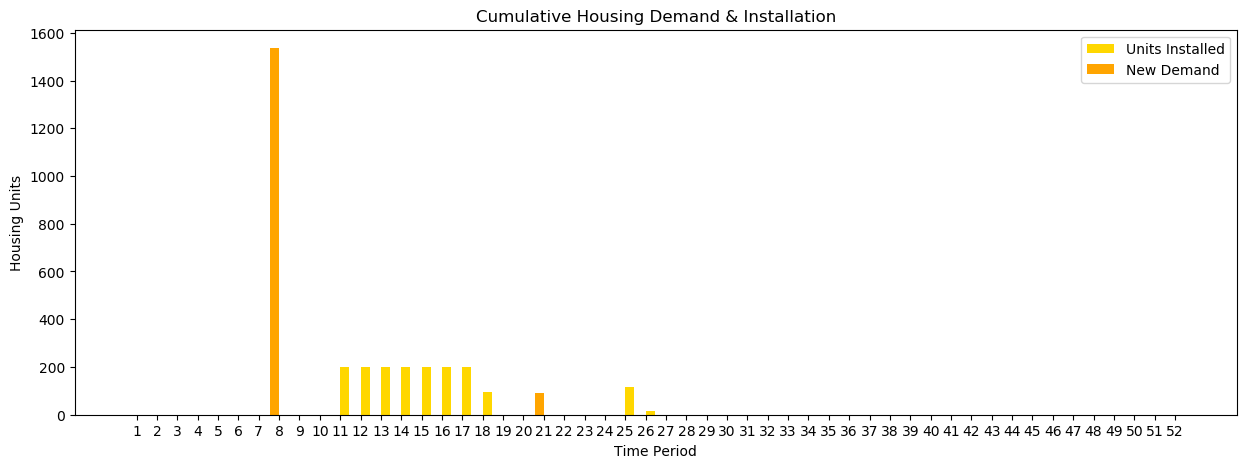

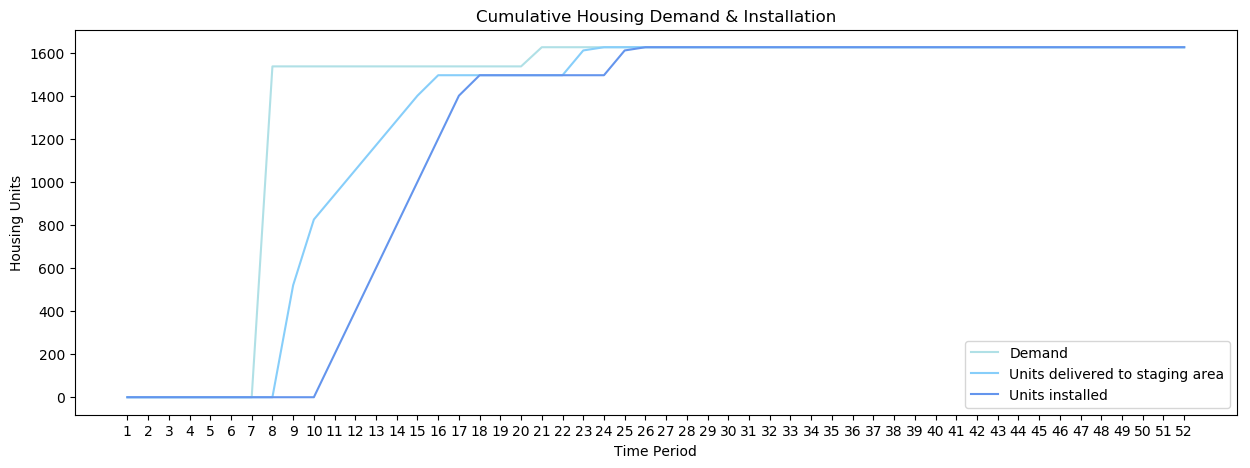

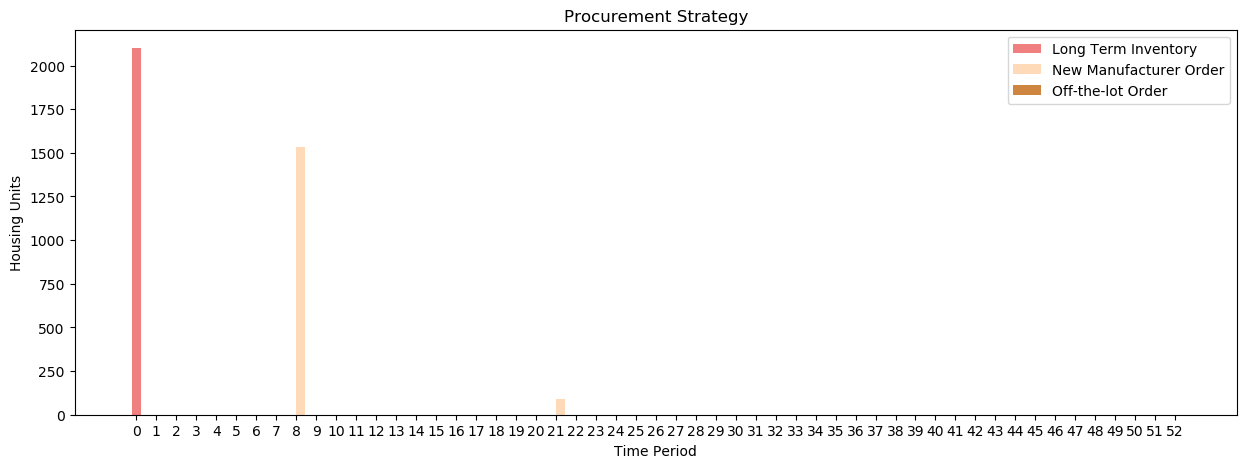

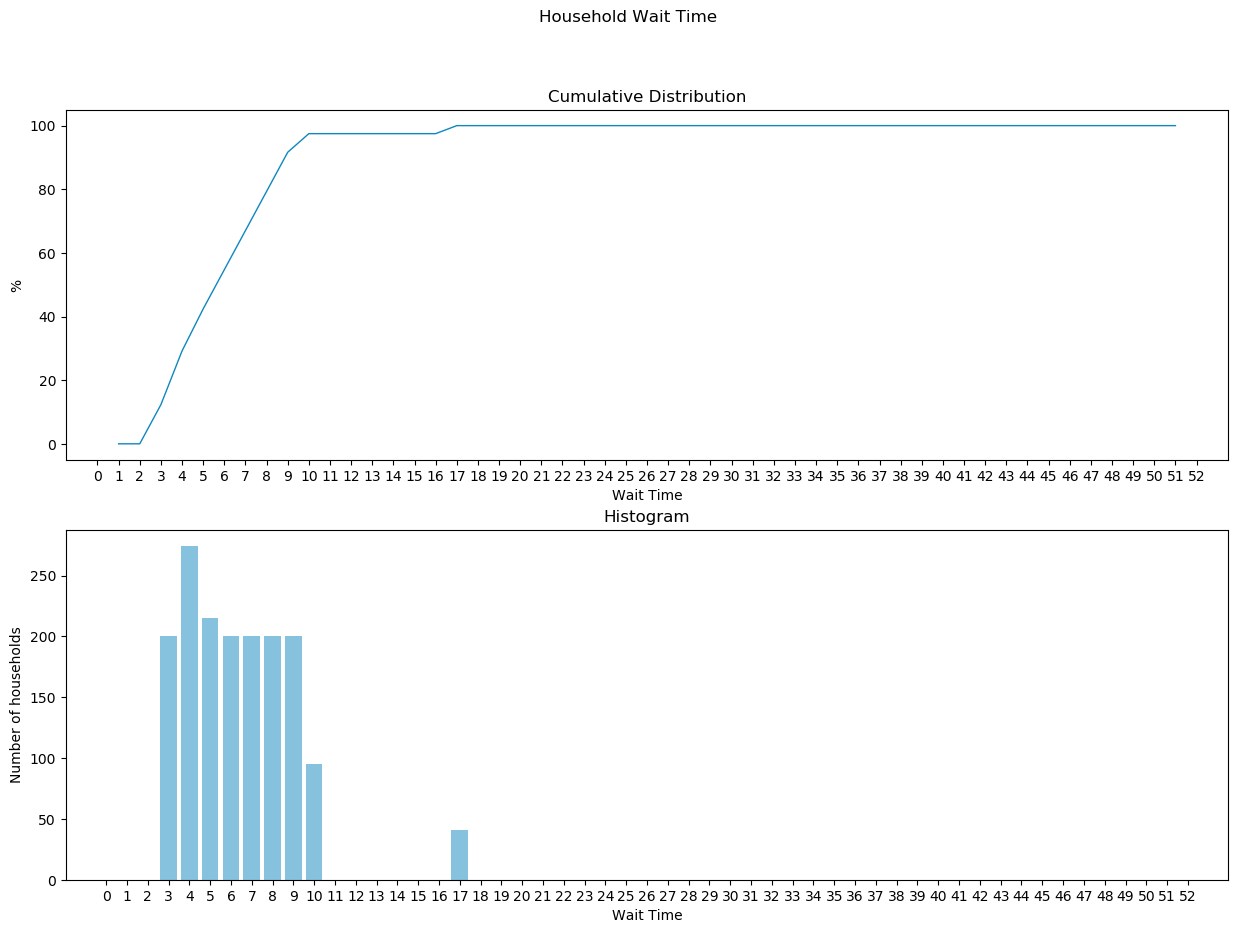

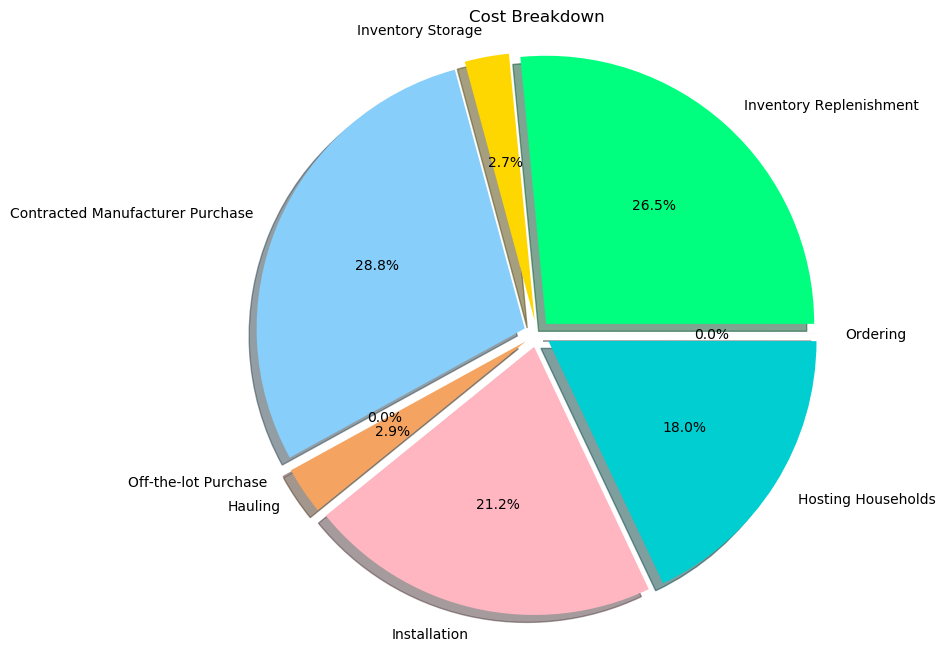

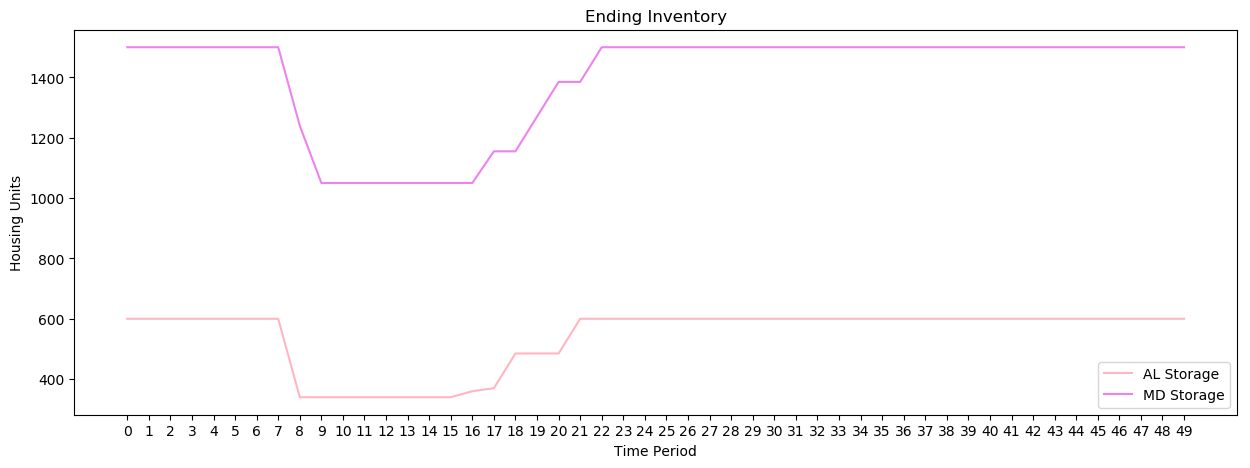

 44.098020 seconds (68.45 M allocations: 3.318 GiB, 7.94% gc time)


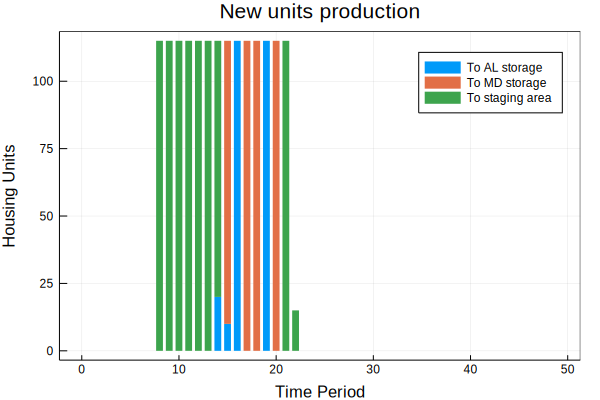

In [43]:
#THIS:
#demand = zeros(disasterseason);
#demand[5] = -100; demand[10] = -900; demand[1] = -1500;

#OR THIS:
Random.seed!(123)
demand = gimmeahouse(disasterscalefactor1, disasterscalefactor2, disasterseason);    

@time singlescenario()

----------------------------------------------------------

## DEMO (2) - Overall Evaluation
In this case, we're looking at the performance of a supply chain configuration under a large array of simulated disaster scenarios:

Optimize a model with 1461 rows, 1250 columns and 5322 nonzeros
Variable types: 886 continuous, 364 integer (364 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [5e+01, 1e+12]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 1442.000000000
MIP start did not produce a new incumbent solution

Presolve removed 767 rows and 386 columns
Presolve time: 0.01s
Presolved: 694 rows, 864 columns, 2587 nonzeros
Variable types: 680 continuous, 184 integer (184 binary)

Root relaxation: objective 6.073101e+15, 730 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6.0731e+15    0   56          - 6.0731e+15      - 

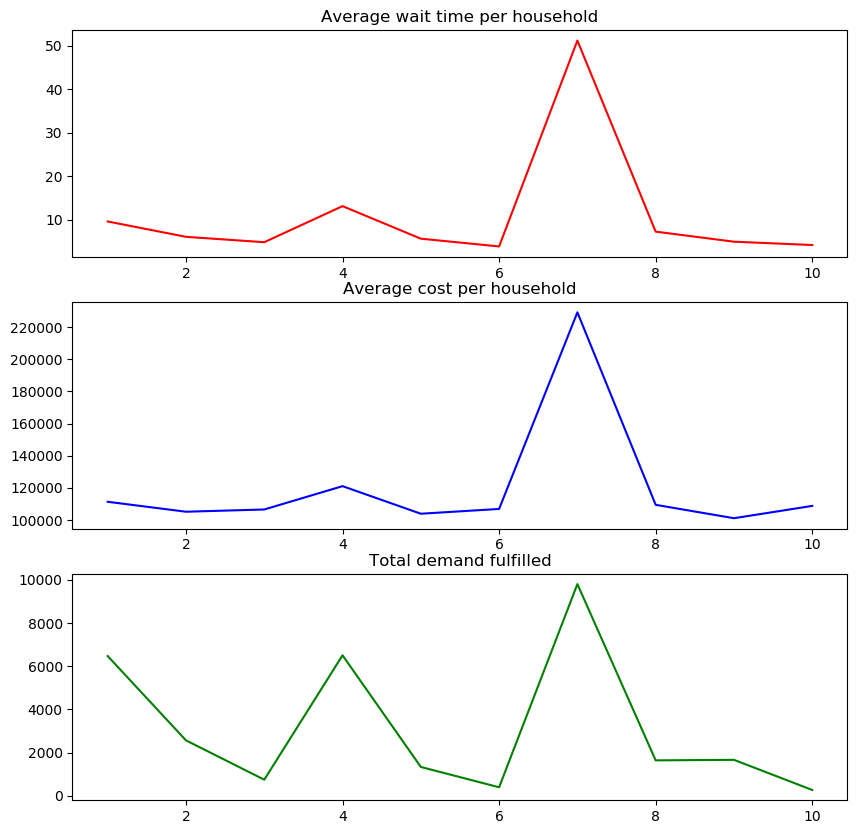

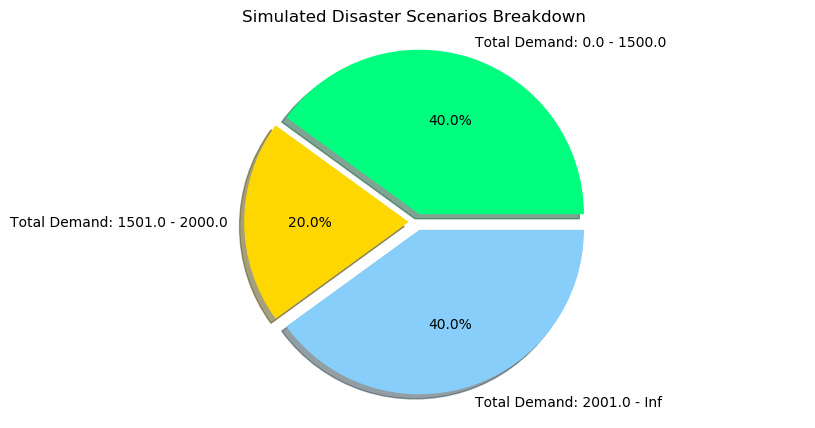

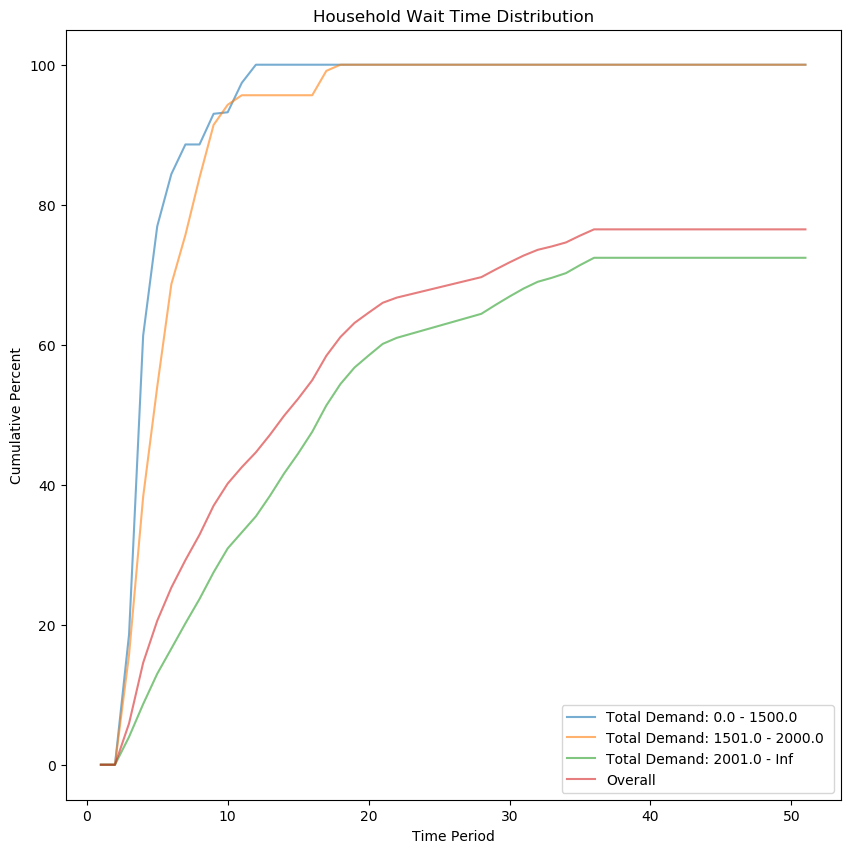

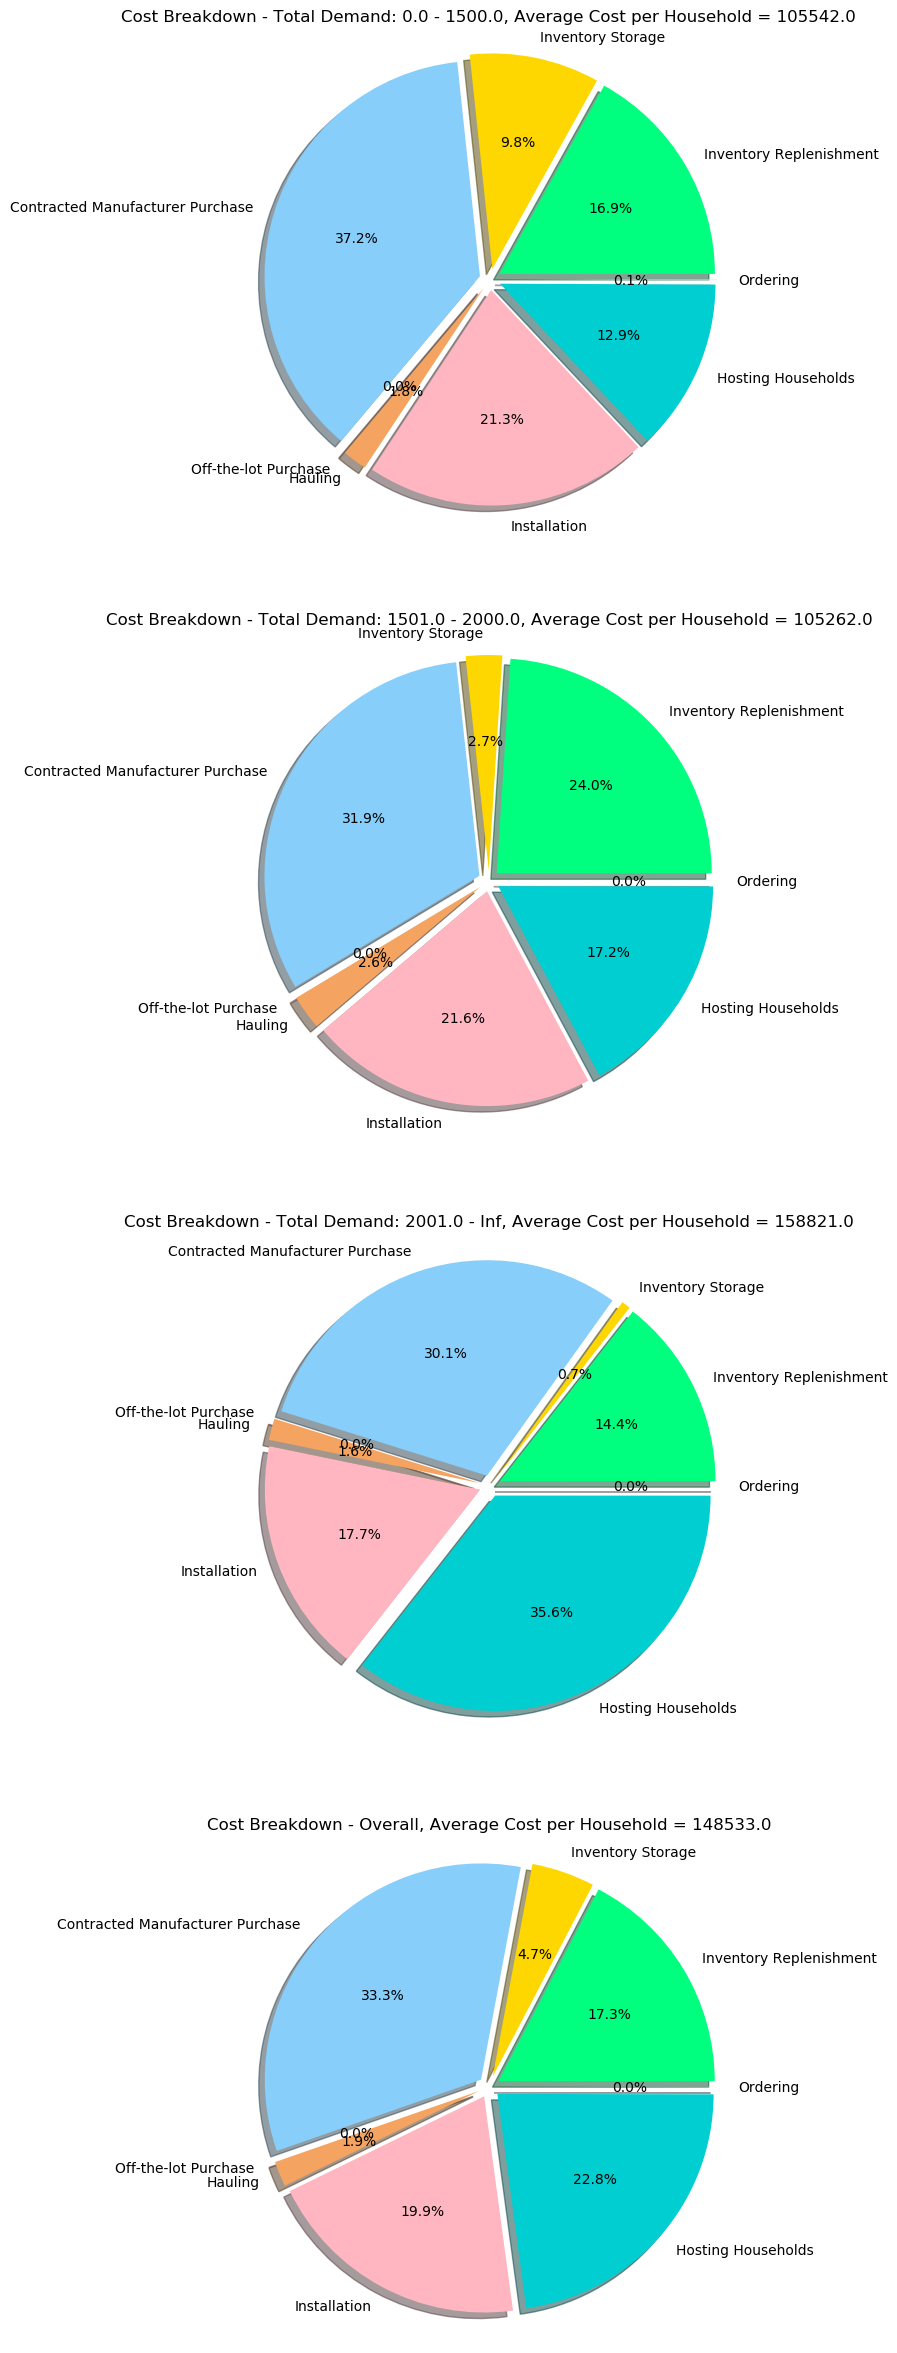

.209523 seconds (120.32 k allocations: 6.338 MiB)


In [45]:
n_simulation= 10;
disasterrange = [range(0,1500), range(1501,2000), range(2001,Inf)] 

@time scenariosoverall(n_simulation,disasterrange)

-----------------------------------------------------------------

In [68]:
println(waittimeoverall)

[0.0, 0.0, 15.0234, 23.1983, 32.7697, 40.6411, 48.2788, 56.1502, 65.0932, 73.2864, 79.1573, 83.9263, 87.0894, 89.9338, 92.6659, 93.4491, 94.0562, 94.9092, 95.8776, 96.4847, 97.0919, 98.0025, 98.6097, 99.2168, 99.8239, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


## DEMO (3) - Determine optimal number of runs per simulation
In this case, we're looking at how some of the average critical performance metrics changes from simulation to simulation:

Optimize a model with 1461 rows, 1302 columns and 5373 nonzeros
Variable types: 886 continuous, 416 integer (416 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [5e+01, 1e+12]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 234.000000000
MIP start did not produce a new incumbent solution

Presolve removed 921 rows and 530 columns
Presolve time: 0.01s
Presolved: 540 rows, 772 columns, 1879 nonzeros
Variable types: 600 continuous, 172 integer (172 binary)
Presolve removed 88 rows and 88 columns
Presolved: 452 rows, 684 columns, 1688 nonzeros


Root relaxation: objective 1.134500e+15, 846 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

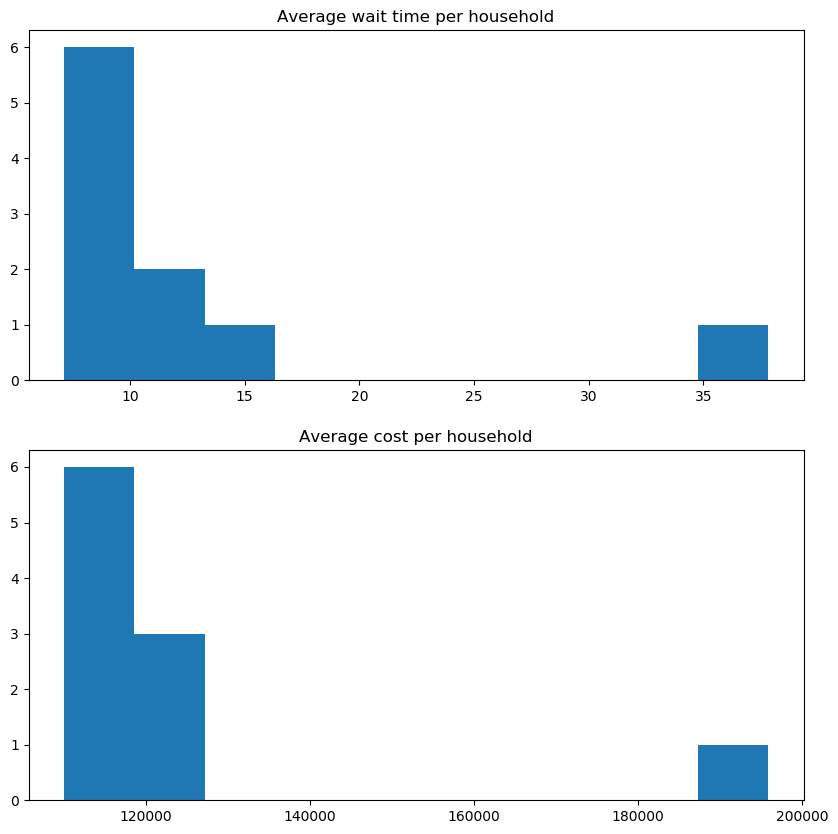

[Normal{Float64}(μ=12.907, σ=8.53383) Normal{Float64}(μ=1.2268e5, σ=24661.6)]
9e+14  0.17%  21.6    0s
*  527   168              45    7.844002e+14 7.8369e+14  0.09%  18.4    0s
H  528   168                    7.844002e+14 7.8369e+14  0.09%  18.3    0s
*  529   168              45    7.844002e+14 7.8369e+14  0.09%  18.3    0s
*  556   152              40    7.843002e+14 7.8369e+14  0.08%  18.1    0s

Cutting planes:
  Gomory: 29
  Cover: 1
  MIR: 6
  Flow cover: 24
  Inf proof: 5

Explored 754 nodes (18027 simplex iterations) in 1.60 seconds
Thread count was 4 (of 4 available processors)

Solution count 7: 7.843e+14 7.844e+14 7.844e+14 ... 1.5265e+15

Optimal solution found (tolerance 1.00e-04)
Best objective 7.843001857492e+14, best bound 7.842523563314e+14, gap 0.0061%
Optimize a model with 1461 rows, 1302 columns and 5373 nonzeros
Variable types: 886 continuous, 416 integer (416 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [5e+01, 1e+12]
  Bou

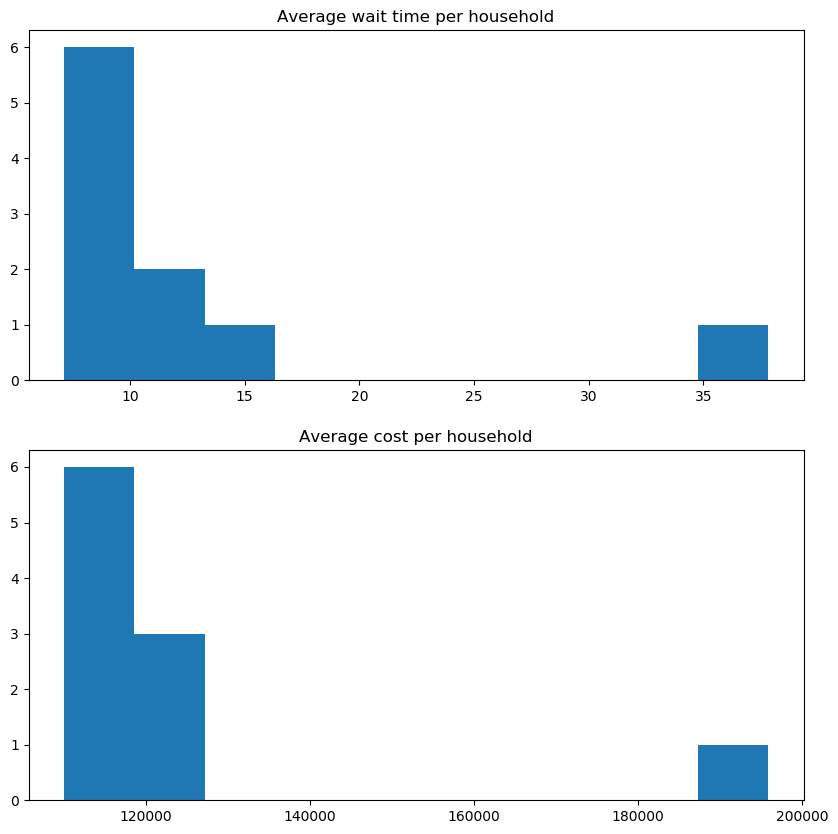

In [43]:
confidenceinterval(10,5)

In [44]:
confidenceinterval(100,20)

Optimize a model with 1461 rows, 1302 columns and 5373 nonzeros
Variable types: 886 continuous, 416 integer (416 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [5e+01, 1e+12]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 7135.000000000
MIP start did not produce a new incumbent solution

Presolve removed 1013 rows and 655 columns
Presolve time: 0.01s
Presolved: 448 rows, 647 columns, 1628 nonzeros
Variable types: 503 continuous, 144 integer (144 binary)
Presolve removed 73 rows and 72 columns
Presolved: 375 rows, 575 columns, 1476 nonzeros

Extra 336 simplex iterations after uncrush

Root relaxation: objective 9.850805e+13, 916 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

InterruptException: InterruptException:

   Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.1638e+15    0   77 3.0606e+15 1.1638e+15  62.0%     -    0s
     0     0 1.1639e+15    0   75 3.0606e+15 1.1639e+15  62.0%     -    0s
H    0     0                    2.258600e+15 1.1639e+15  48.5%     -    0s
     0     0 1.1640e+15    0   80 2.2586e+15 1.1640e+15  48.5%     -    0s
H    0     0                    2.128300e+15 1.1640e+15  45.3%     -    0s
     0     0 1.1640e+15    0   80 2.1283e+15 1.1640e+15  45.3%     -    0s
     0     0 1.1640e+15    0   78 2.1283e+15 1.1640e+15  45.3%     -    0s
     0     2 1.1640e+15    0   83 2.1283e+15 1.1640e+15  45.3%     -    0s
H    3     6                    1.651000e+15 1.1640e+15  29.5%   414    0s
H    4     6                    1.601800e+15 1.1640e+15  27.3%   314    0s
H   70    53                    1.438200e+15 1.1640e+15  19.1%  47.7    0s
H   89    73                    1.34340

Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 4048.000000000
Loaded MIP start with objective 8.19601e+09

Presolve removed 664 rows and 336 columns
Presolve time: 0.01s
Presolved: 644 rows, 841 columns, 2269 nonzeros
Variable types: 656 continuous, 185 integer (185 binary)

Root relaxation: objective 6.729704e+09, 637 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6.7297e+09    0   35 8.1960e+09 6.7297e+09  17.9%     -  

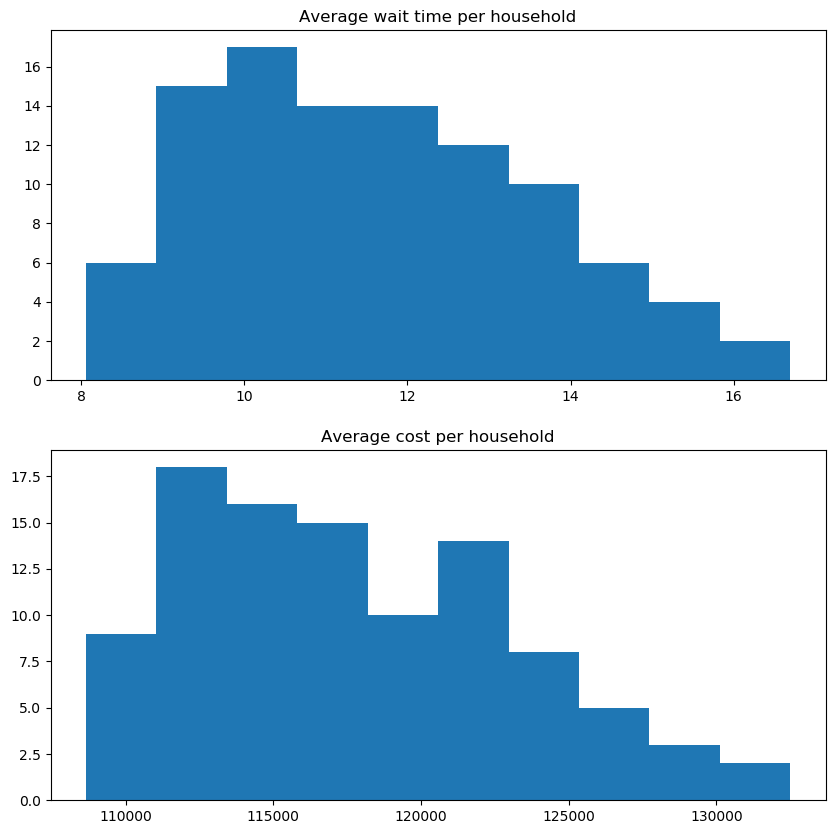

[Normal{Float64}(μ=11.5983, σ=1.95525) Normal{Float64}(μ=1.17693e5, σ=5486.03)]
8033e+09    0    8 3.8065e+09 3.8033e+09  0.08%     -    0s
     0     0 3.8033e+09    0    8 3.8065e+09 3.8033e+09  0.08%     -    0s
     0     0 3.8033e+09    0    9 3.8065e+09 3.8033e+09  0.08%     -    0s
     0     0 3.8033e+09    0   10 3.8065e+09 3.8033e+09  0.08%     -    0s
     0     0 3.8033e+09    0    7 3.8065e+09 3.8033e+09  0.08%     -    0s
H    0     0                    3.803386e+09 3.8033e+09  0.00%     -    0s

Cutting planes:
  Learned: 5
  Gomory: 2
  Cover: 5
  MIR: 4
  Flow cover: 9

Explored 1 nodes (918 simplex iterations) in 0.09 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 3.80339e+09 3.8065e+09 3.8833e+09 4.07634e+09 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.803386366953e+09, best bound 3.803330143733e+09, gap 0.0015%
Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240

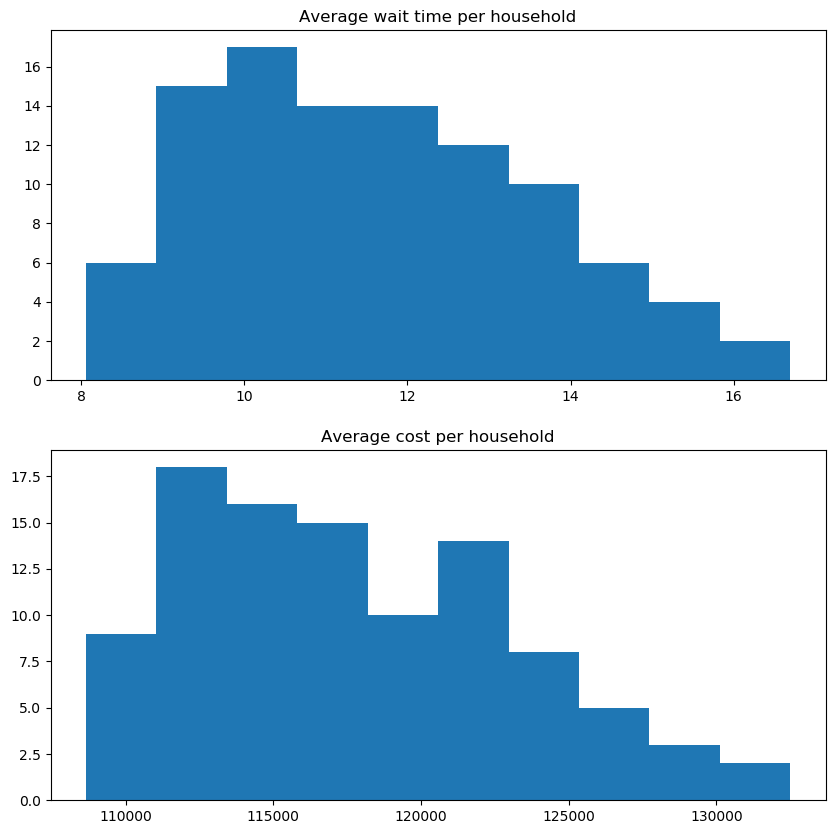

In [44]:
confidenceinterval(100,50)

Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 2560.000000000
MIP start did not produce a new incumbent solution

Presolve removed 918 rows and 647 columns
Presolve time: 0.01s
Presolved: 390 rows, 530 columns, 1330 nonzeros
Variable types: 433 continuous, 97 integer (97 binary)

Root relaxation: objective 2.822137e+09, 322 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2.8221e+09    0    2          - 2.8221e+09      -   

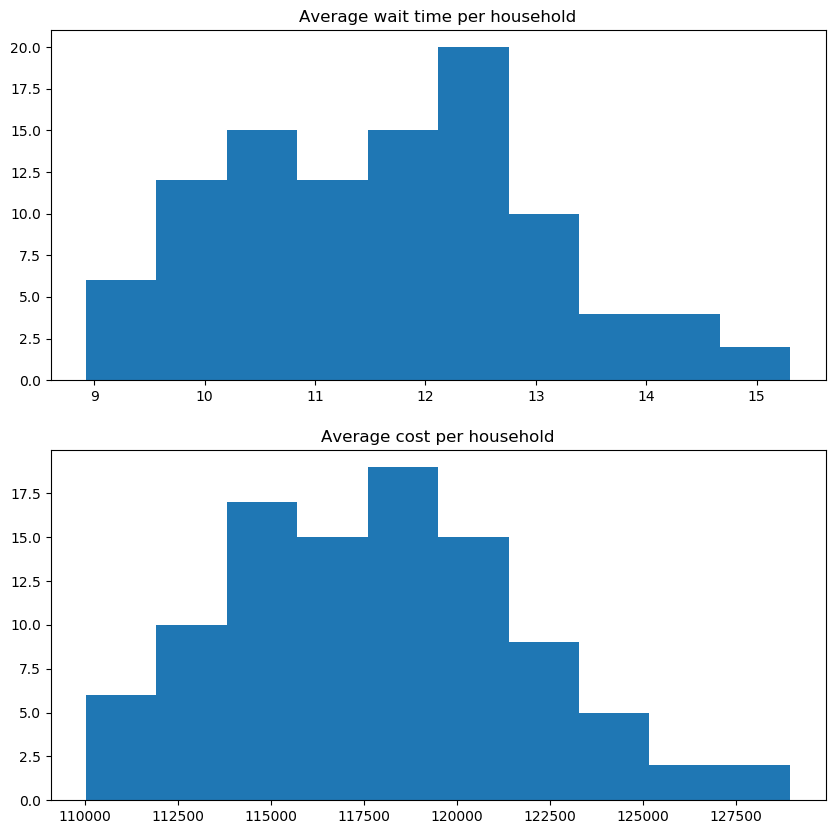

[Normal{Float64}(μ=11.6287, σ=1.41586) Normal{Float64}(μ=1.17765e5, σ=3992.84)]
ode    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      3.9486e+07 3.9486e+07  0.00%     -    0s

Explored 0 nodes (115 simplex iterations) in 0.01 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 3.94863e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.948630000000e+07, best bound 3.948630000000e+07, gap 0.0000%
Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates 

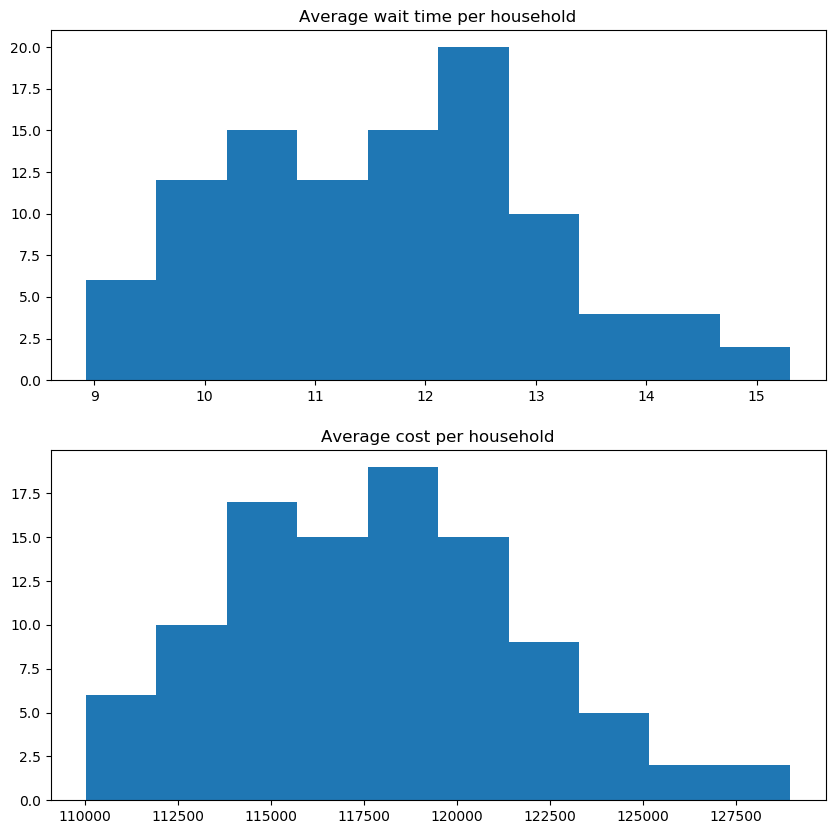

In [45]:
confidenceinterval(100,100)

Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [9e+01, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 1425.000000000
MIP start did not produce a new incumbent solution

Presolve removed 878 rows and 502 columns
Presolve time: 0.01s
Presolved: 430 rows, 675 columns, 1624 nonzeros
Variable types: 630 continuous, 45 integer (45 binary)

Root relaxation: objective 1.433090e+08, 223 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.4331e+08    0    2          - 1.4331e+08      -   

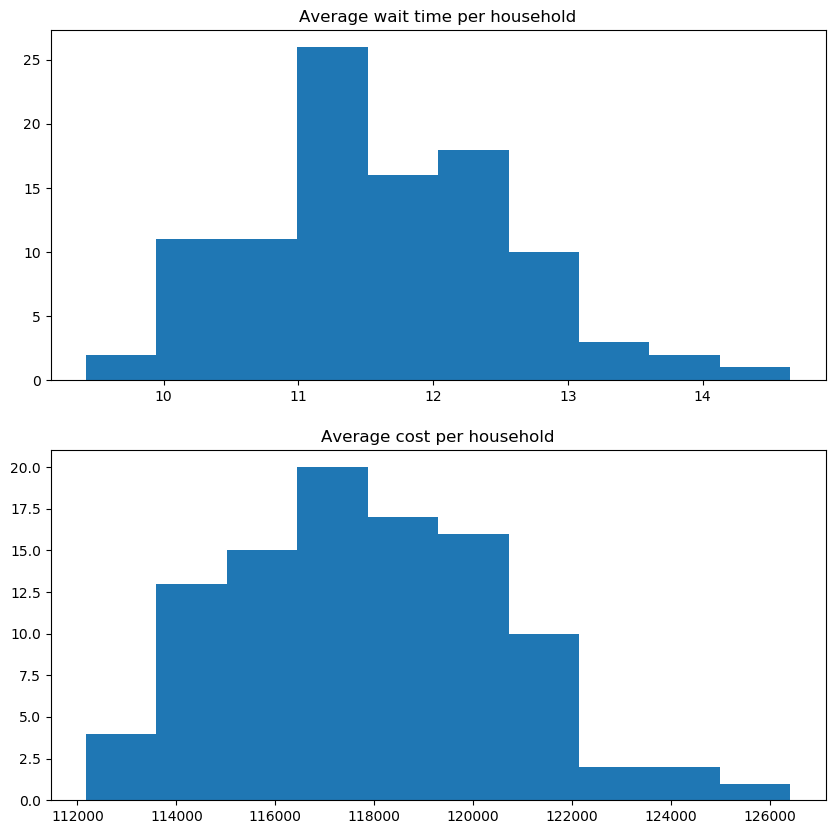

[Normal{Float64}(μ=11.6479, σ=0.969532) Normal{Float64}(μ=117877.0, σ=2732.69)]
1.2194e+09      -     -    0s
Another try with MIP start
H    0     0                    1.228537e+09 1.2194e+09  0.74%     -    0s
H    0     0                    1.219490e+09 1.2194e+09  0.00%     -    0s

Explored 1 nodes (307 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 1.21949e+09 1.22854e+09 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.219490083887e+09, best bound 1.219440083887e+09, gap 0.0041%
Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution

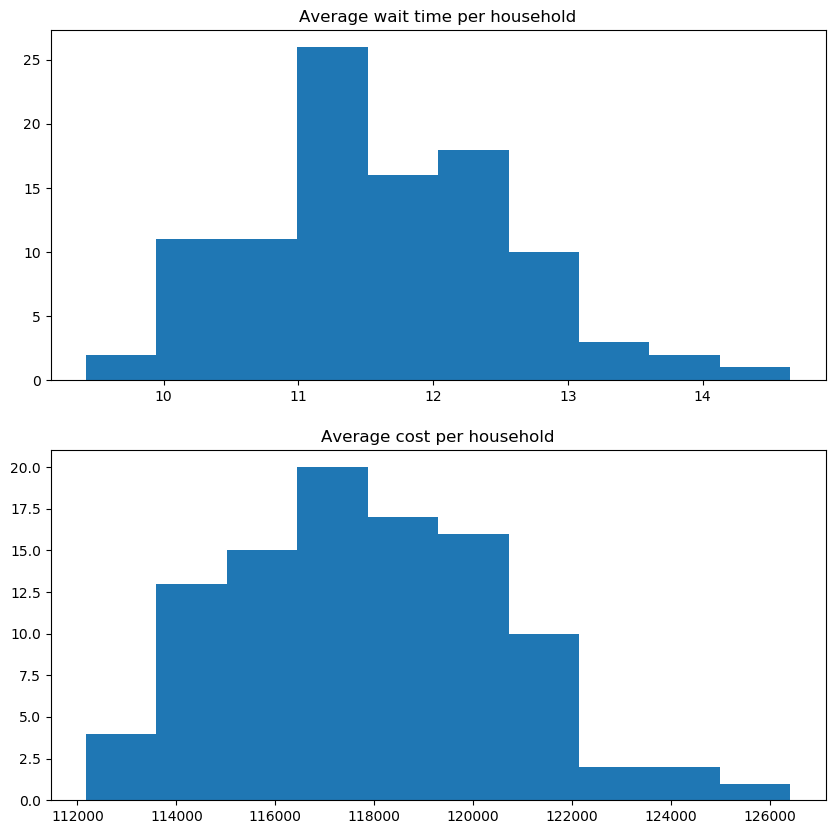

In [47]:
confidenceinterval(100,250)

Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 57.000000000
Loaded MIP start with objective 8.53945e+07

Presolve removed 1051 rows and 767 columns
Presolve time: 0.01s
Presolved: 257 rows, 410 columns, 930 nonzeros
Variable types: 382 continuous, 28 integer (28 binary)

Root relaxation: objective 8.516994e+07, 115 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8.5170e+07    0    3 8.5395e+07 8.5170e+07  0.26%     -    0s

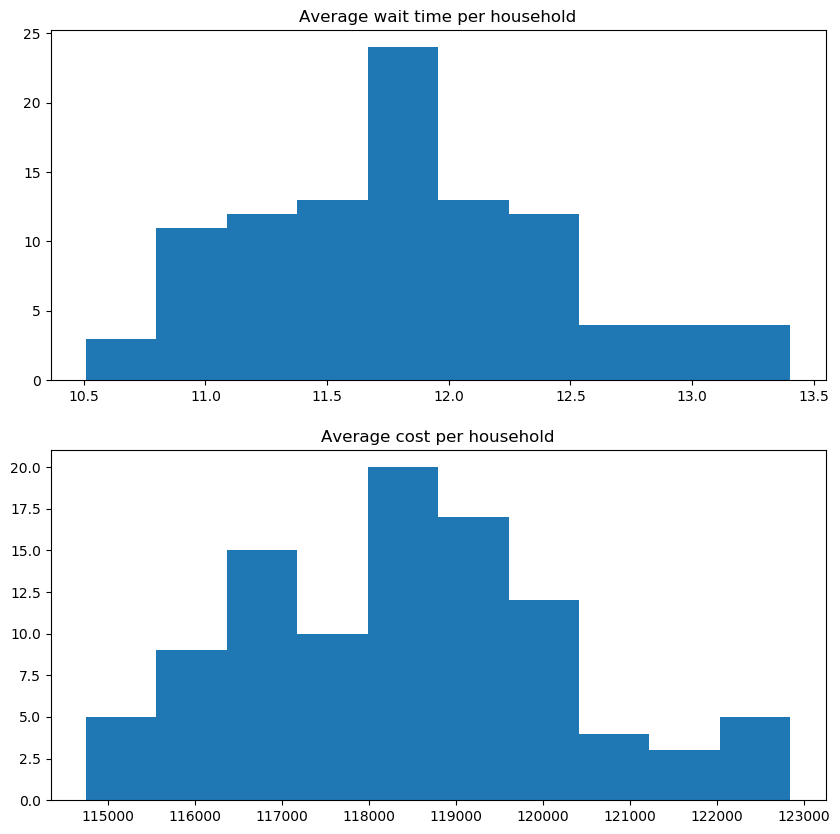

[Normal{Float64}(μ=11.8397, σ=0.640579) Normal{Float64}(μ=1.18394e5, σ=1834.11)]
705576160000e+08, best bound 1.705476160000e+08, gap 0.0059%
Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 7741.000000000
Loaded MIP start with objective 2.52287e+10

Presolve removed 679 rows and 356 columns
Presolve time: 0.01s
Presolved: 629 rows, 821 columns, 2336 nonzeros
Variable types: 645 continuous, 176 integer (176 binary)

Root relaxation: objective 1.196130e+10, 591 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

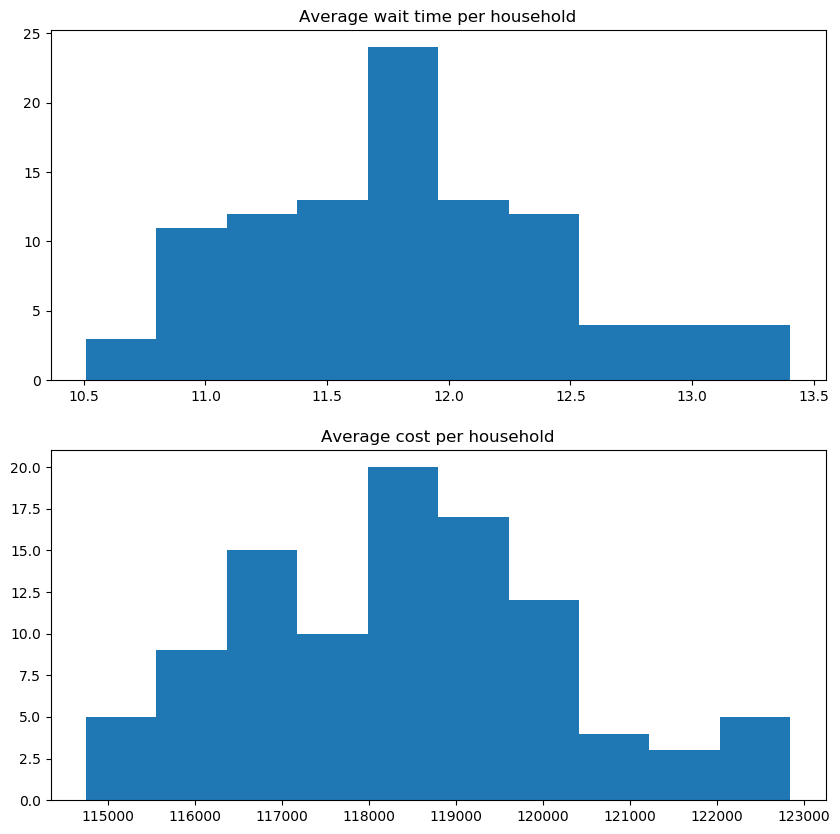

In [43]:
confidenceinterval(100,500)

Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [4e+01, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 2865.000000000
Loaded MIP start with objective 3.9463e+09

Presolve removed 694 rows and 344 columns
Presolve time: 0.02s
Presolved: 614 rows, 833 columns, 2367 nonzeros
Variable types: 687 continuous, 146 integer (146 binary)

Root relaxation: objective 3.195536e+09, 428 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.1955e+09    0   22 3.9463e+09 3.1955e+09  19.0%     -   

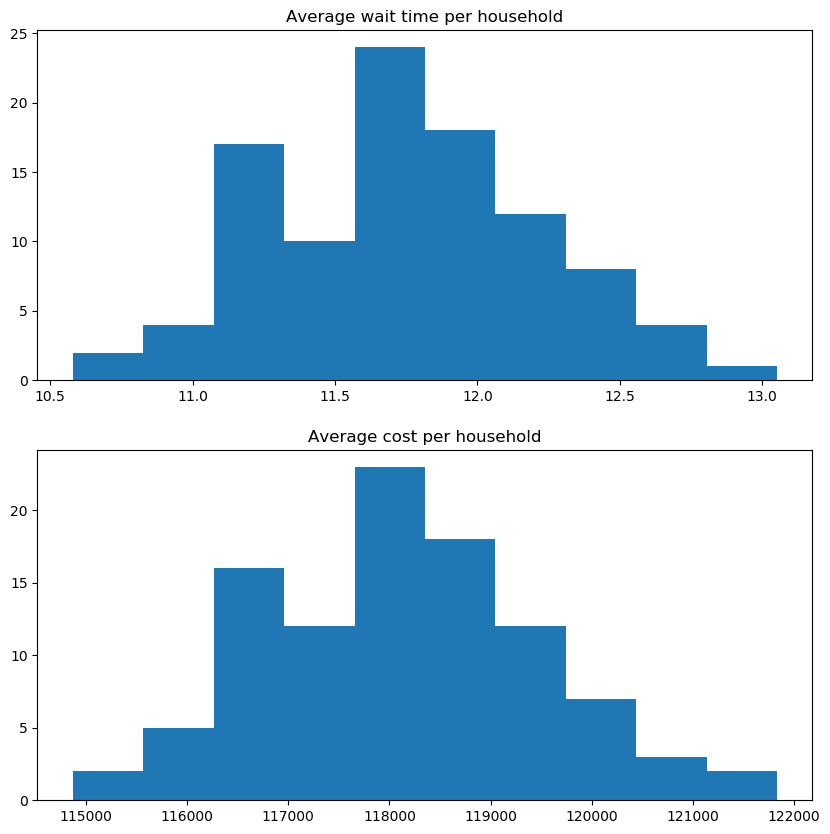

[Normal{Float64}(μ=11.7415, σ=0.470035) Normal{Float64}(μ=1.18095e5, σ=1348.95)]
+09 1.4050e+09  0.38%     -    0s
H    0     0                    1.405016e+09 1.4050e+09  0.00%     -    0s

Explored 1 nodes (336 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 1.40502e+09 1.41027e+09 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.405015964016e+09, best bound 1.404958232361e+09, gap 0.0041%
Optimize a model with 1308 rows, 1177 columns and 5678 nonzeros
Variable types: 937 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [7e+03, 5e+07]
  Bounds range     [1e+00, 1e+07]
  RHS range        [1e+02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start did not produce a new incumbent solution
MIP start violates constraint R821 by 664.000000000
Loaded MIP start with objective 1.10811e+09


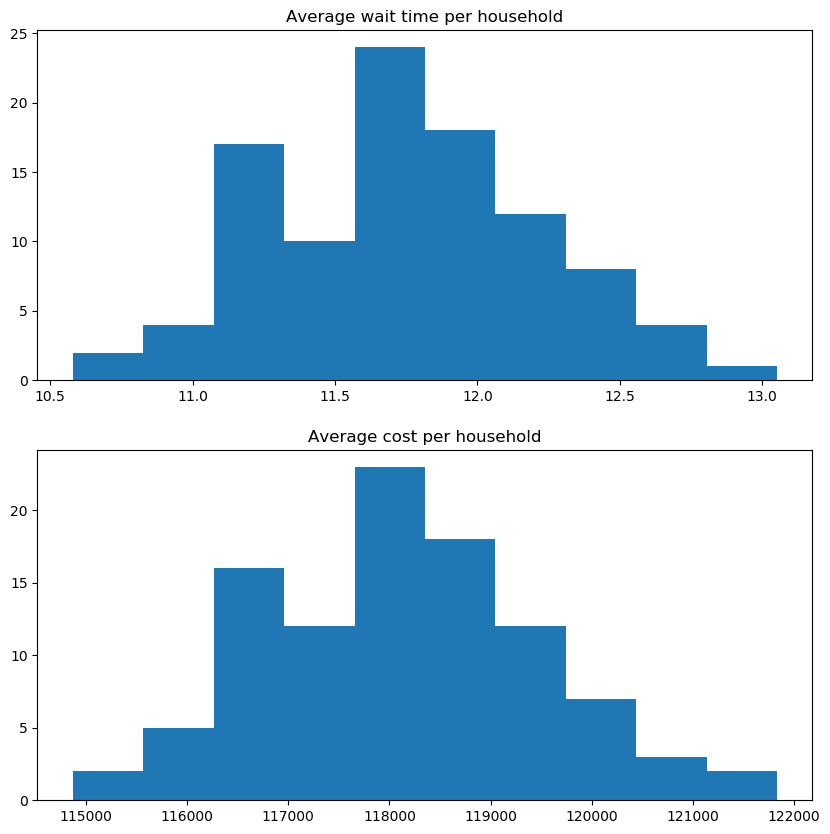

In [44]:
confidenceinterval(100,1000)

In [56]:
for i = disasterseason:-1:1
    println(i)
end

25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
